In [48]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, brentq
from scipy.integrate import quad, simps

import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'#['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
font = {'family': 'Times New Roman',
        #'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

In [2]:
# aesthetic definitions for the plots
# font = {'size'   : 16, 'family':'STIXGeneral'}
# axislabelfontsize='large'
# matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams["figure.figsize"] = [8.0,6.0]

%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (13, 8)
plt.rcParams['font.family'] = 'STIXGeneral'
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams['font.serif'] = ['New Times Roman']
# plt.rc('text', usetex=True)

In [3]:
# import classy module
from classy import Class

# Functions

In [4]:
def log_interp_fn(xArr, yArr):
    
    Lfn = interp1d(np.log10(xArr), np.log10(yArr))
    
    return Lfn

def interp_fn(x, Lfn):
    
    return 10.**(Lfn(np.log10(x)))

In [5]:
def zeros(fn, arr, *args):
    """
    Find where a function crosses 0. Returns the zeroes of the function.

    Parameters
    ----------
    fn : function
    arr : array of arguments for function
    *args : any other arguments the function may have
    """

    # the reduced function, with only the argument to be solved for (all other arguments fixed):
    def fn_reduced(array): return fn(array, *args)

    # the array of values of the function:
    fn_arr = fn_reduced(arr)

    # looking where the function changes sign...
    sign_change_arr = np.where(np.logical_or((fn_arr[:-1] < 0.) * (fn_arr[1:] > 0.),
                                             (fn_arr[:-1] > 0.) * (fn_arr[1:] < 0.))
                               )[0]

    # or, just in case, where it is exactly 0!
    exact_zeros_arr = np.where(fn_arr == 0.)[0]

    # defining the array of 0-crossings:
    cross_arr = []

    # first, interpolating between the sign changes
    if len(sign_change_arr) > 0:
        for i in range(len(sign_change_arr)):
            cross_arr.append(
                brentq(fn_reduced, arr[sign_change_arr[i]],
                       arr[sign_change_arr[i] + 1])
            )

    # and then adding those places where it is exactly 0
    if len(exact_zeros_arr) > 0:
        for i in range(len(exact_zeros_arr)):
            cross_arr.append(arr[exact_zeros_arr[i]])

    # sorting the crossings in increasing order:
    cross_arr = np.sort(np.array(cross_arr))

    return cross_arr

In [6]:
def klist(early_dreco):
    
    if early_dreco:
        
        temp = list(np.round(np.logspace(-1, 1., 48),3))
        return ([1.e-3, 0.01] + temp)
        
    else:
        temp = list(np.round(np.linspace(0.01, 0.1, 47),3))
        return ([1.e-3] + temp + [1., 10.])

def k_str(early_dreco):
    
    temp = ''
    for k in klist(early_dreco):
        temp += str(k)+','
    
    return temp[:-1]

# Early Dark Recombination

Large $m_{e'} / m_{p'}$ ratio

## Preamble

In [7]:
# Lambda CDM

bare_settings = {'omega_b':0.02300579,
                 # 'omega_cdm':0.1243789,
                 'omega_dm_tot':0.1243789,
                 # '100*theta_s':1.056498,
                 'h':0.7139304,
                 # 'A_s':2.100549e-09,
                 'ln10^{10}A_s':3.024349,
                 'n_s':0.971559,
                 'tau_reio':0.05018996,
                 'N_ur':2.046,
                 'N_ncdm':1,
                 'm_ncdm':0.06,
                 'T_ncdm':0.7137658555036082,
                 'YHe':'BBN',
                 'output':'tCl,lCl',
                 'lensing':'yes',
                 'YHe_twin':0.0,
                 'm_p_dark':1.,
                 'log10_alphafs_dark':-2.0,
                 'dof_extra_twin':12.5,
                 'log10_me_mp_dark_ratio':0.,
                 'Delta_N_twin':0.1,
                 'r_all_twin':1.e-6}

more_settings = {'P_k_max_1/Mpc':100.0,
                 'z_max_pk':3,
                 'k_output_values':k_str(True),
                 'background_verbose':3,
                 'thermodynamics_verbose':3,
                 'input_verbose':5}

common_settings = dict(bare_settings, **more_settings)
common_settings['output'] = 'tCl,pCl,lCl,mPk'

In [8]:
lcdm = Class()
lcdm.set(common_settings)
%time
lcdm.compute()

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 8.34 µs


In [9]:
target_ths = lcdm.theta_s_100()

In [10]:
# lcdm.empty()

In [11]:
# nuADaM

# Fail-point #2
nuadam_settings = {'YHe_twin':0.0,
                   'm_p_dark':1.,
                   'log10_alphafs_dark':-2.0,
                   'dof_extra_twin':12.5,
                   'log10_me_mp_dark_ratio':-3.,
                   'Delta_N_twin':0.1,
                   'r_all_twin':0.04
                  }

nuadam_settings = dict(bare_settings, **nuadam_settings)

# searching for new omega_dm_tot so that z_eq is fixed
nuadam = Class()
nuadam.set(nuadam_settings)
nuadam.compute()

print(lcdm.z_eq(), nuadam.z_eq())

3476.208989622164 3476.208989622164


In [12]:
# now searching for 'h' such that theta_s is fixed
loop_settings = dict(**nuadam_settings)
loop_settings['h'] = 0.7138951043686523 # found it from previous iteration

h_vals = []
h_vals.append(loop_settings['h'])

hmin = h_vals[-1]*0.9
hmax = h_vals[-1]*1.1

i = 0
while True:
    
    i += 1
    
    if i == 1:
        hpt = h_vals[-1]
    else:
        hpt = (hmax + hmin) / 2.
    
    loop_settings['h'] = hpt
    
    nuadam = Class()
    nuadam.set(loop_settings)
    nuadam.compute()
    
    th_try = nuadam.theta_s_100()
    
    nuadam.empty()
    
    error = (th_try - target_ths)/target_ths
    
    print('h=', hpt, ', theta_s=', th_try, ', error=', error)
    
    if i >= 100:
        print('i >= 100')
        break
    
    if abs(error) < 1.e-4:
        print('done!')
        break
    elif error < 0:
        hmin = hpt
        h_vals.append(hpt)
    else:
        hmax = hpt
        h_vals.append(hpt)

h= 0.7138951043686523 , theta_s= 1.053011614032082 , error= 3.259231780072022e-06
done!


In [13]:
# now we add the other settings

nuadam_settings['h'] = h_vals[-1]
nuadam_settings['output'] = 'tCl,pCl,lCl,mPk'

nuadam_settings = dict(more_settings, **nuadam_settings)

nuadam = Class()
nuadam.set(nuadam_settings)
nuadam.compute()

In [36]:
models = {'nuadam':nuadam, 'lcdm':lcdm}

In [14]:
kvals = list(klist(True))

def pert(model, yval, k, x='a'):
    
    idx = kvals.index(k)
    
    results = model.get_perturbations()['scalar'][idx]
    
    if x=='a':
        xvals = np.array(results['a'])
    else:
        xvals = np.array(results['tau [Mpc]'])
    yvals = np.array(results[yval])
    
    return xvals, yvals

In [37]:
nuadam.get_background()

{'z': array([1.00000000e+14, 9.89308584e+13, 9.78731474e+13, ...,
        2.17307062e-02, 1.08069579e-02, 0.00000000e+00]),
 'proper time [Gyr]': array([7.52255155e-26, 7.68602194e-26, 7.85304463e-26, ...,
        1.30269339e+01, 1.31731090e+01, 1.33199864e+01]),
 'conf. time [Mpc]': array([4.61295713e-09, 4.66206984e-09, 4.71300154e-09, ...,
        1.37151623e+04, 1.37607083e+04, 1.38059838e+04]),
 'H [1/Mpc]': array([2.16785738e+22, 2.12175025e+22, 2.07662374e+22, ...,
        2.40423283e-04, 2.39260786e-04, 2.38129775e-04]),
 'comov. dist.': array([13805.98382749, 13805.98382749, 13805.98382749, ...,
           90.82149703,    45.27550628,     0.        ]),
 'ang.diam.dist.': array([1.38059838e-10, 1.39551845e-10, 1.41059976e-10, ...,
        8.88898576e+01, 4.47914470e+01, 0.00000000e+00]),
 'lum. dist.': array([1.38059838e+18, 1.36583783e+18, 1.35123509e+18, ...,
        9.27951123e+01, 4.57647968e+01, 0.00000000e+00]),
 'comov.snd.hrz.': array([2.66322995e-09, 2.69201137e-09, 2.

In [59]:
Lfns = {}
fns = {}

for name, model in models.items():
    
    zs = model.get_thermodynamics()['z'][1:]
    conf_time = model.get_thermodynamics()['conf. time [Mpc]'][1:]
    rate = model.get_thermodynamics()['tau_idm_dr'][1:]
    
    z_bg = (model.get_background()['z'][::-1])[1:]
    hubble = (model.get_background()['H [1/Mpc]'][::-1])[1:]
    dtau_dz = 1./hubble
    
    Lfns[(name, 'tau')] = log_interp_fn(zs, conf_time)
    Lfns[(name, 'Gamma')] = log_interp_fn(zs, rate)
    Lfns[(name, 'Hubble')] = log_interp_fn(z_bg, hubble)
    Lfns[(name, 'dtau_dz')] = log_interp_fn(z_bg, dtau_dz)
    
    fns[(name, 'tau')] = lambda z: interp_fn(z, Lfns[(name, 'tau')])
    fns[(name, 'Gamma')] = lambda z: interp_fn(z, Lfns[(name, 'Gamma')])
    fns[(name, 'Hubble')] = lambda z: interp_fn(z, Lfns[(name, 'Hubble')])
    fns[(name, 'dtau_dz')] = lambda z: -interp_fn(z, Lfns[(name, 'dtau_dz')])

In [74]:
hubble

array([2.39272504e-04, 2.40434945e-04, 2.41629615e-04, ...,
       2.07661188e+22, 2.12173839e+22, 2.16784554e+22])

In [72]:
zs

array([1.50015002e-02, 3.00030003e-02, 4.50045005e-02, ...,
       9.96781250e+10, 9.98389328e+10, 1.00000000e+11])

In [71]:
z_bg

array([1.08069579e-02, 2.17307062e-02, 3.27725070e-02, ...,
       9.78731474e+13, 9.89308584e+13, 1.00000000e+14])

In [70]:
fns[(name, 'dtau_dz')](zArr)

array([-4.01060028e+03, -4.00919071e+03, -4.00778164e+03, ...,
       -4.74763107e-13, -4.67530881e-13, -4.60408827e-13])

In [75]:
help(quad)

Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate. If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
    
        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::
    
            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)
    
        The ``user_data`` is the d

In [96]:
def Rdark(model, z):
    
    rho0_idm = (model.get_background()['(.)rho_idm_dr'])[0]
    rho0_idr = (model.get_background()['(.)rho_idr'])[0]
    
    res = (3./4.) * (rho0_idm / rho0_idr) / (1. + z)
    
    return res

In [149]:
zArr = np.logspace(np.log10(nuadam.z_d_twin()), 10, 5001)
# zArr = np.logspace(np.log10(nuadam.z_rec_twin()), 10, 5001)

for name, model in models.items():
    
    def Rfn(z): return (Rdark(model, z)**2. + (16./15.)*(1. + Rdark(model, z)))/(6.*(1. + Rdark(model, z))**2.)
    
    intgrArr = -(Rfn(zArr) * fns[(name, 'dtau_dz')](zArr))/fns[(name, 'Gamma')](zArr)
    def integrand(z): return -(Rfn(z) * fns[(name, 'dtau_dz')](z))/fns[(name, 'Gamma')](z)
    
    print(name, 1./np.sqrt(simps(intgrArr, zArr)))
    # print(name, np.sqrt(quad(integrand, 0.1, 1.e3)))

nuadam 2.32817107692819
lcdm 0.021653535955404767


## Perturbations

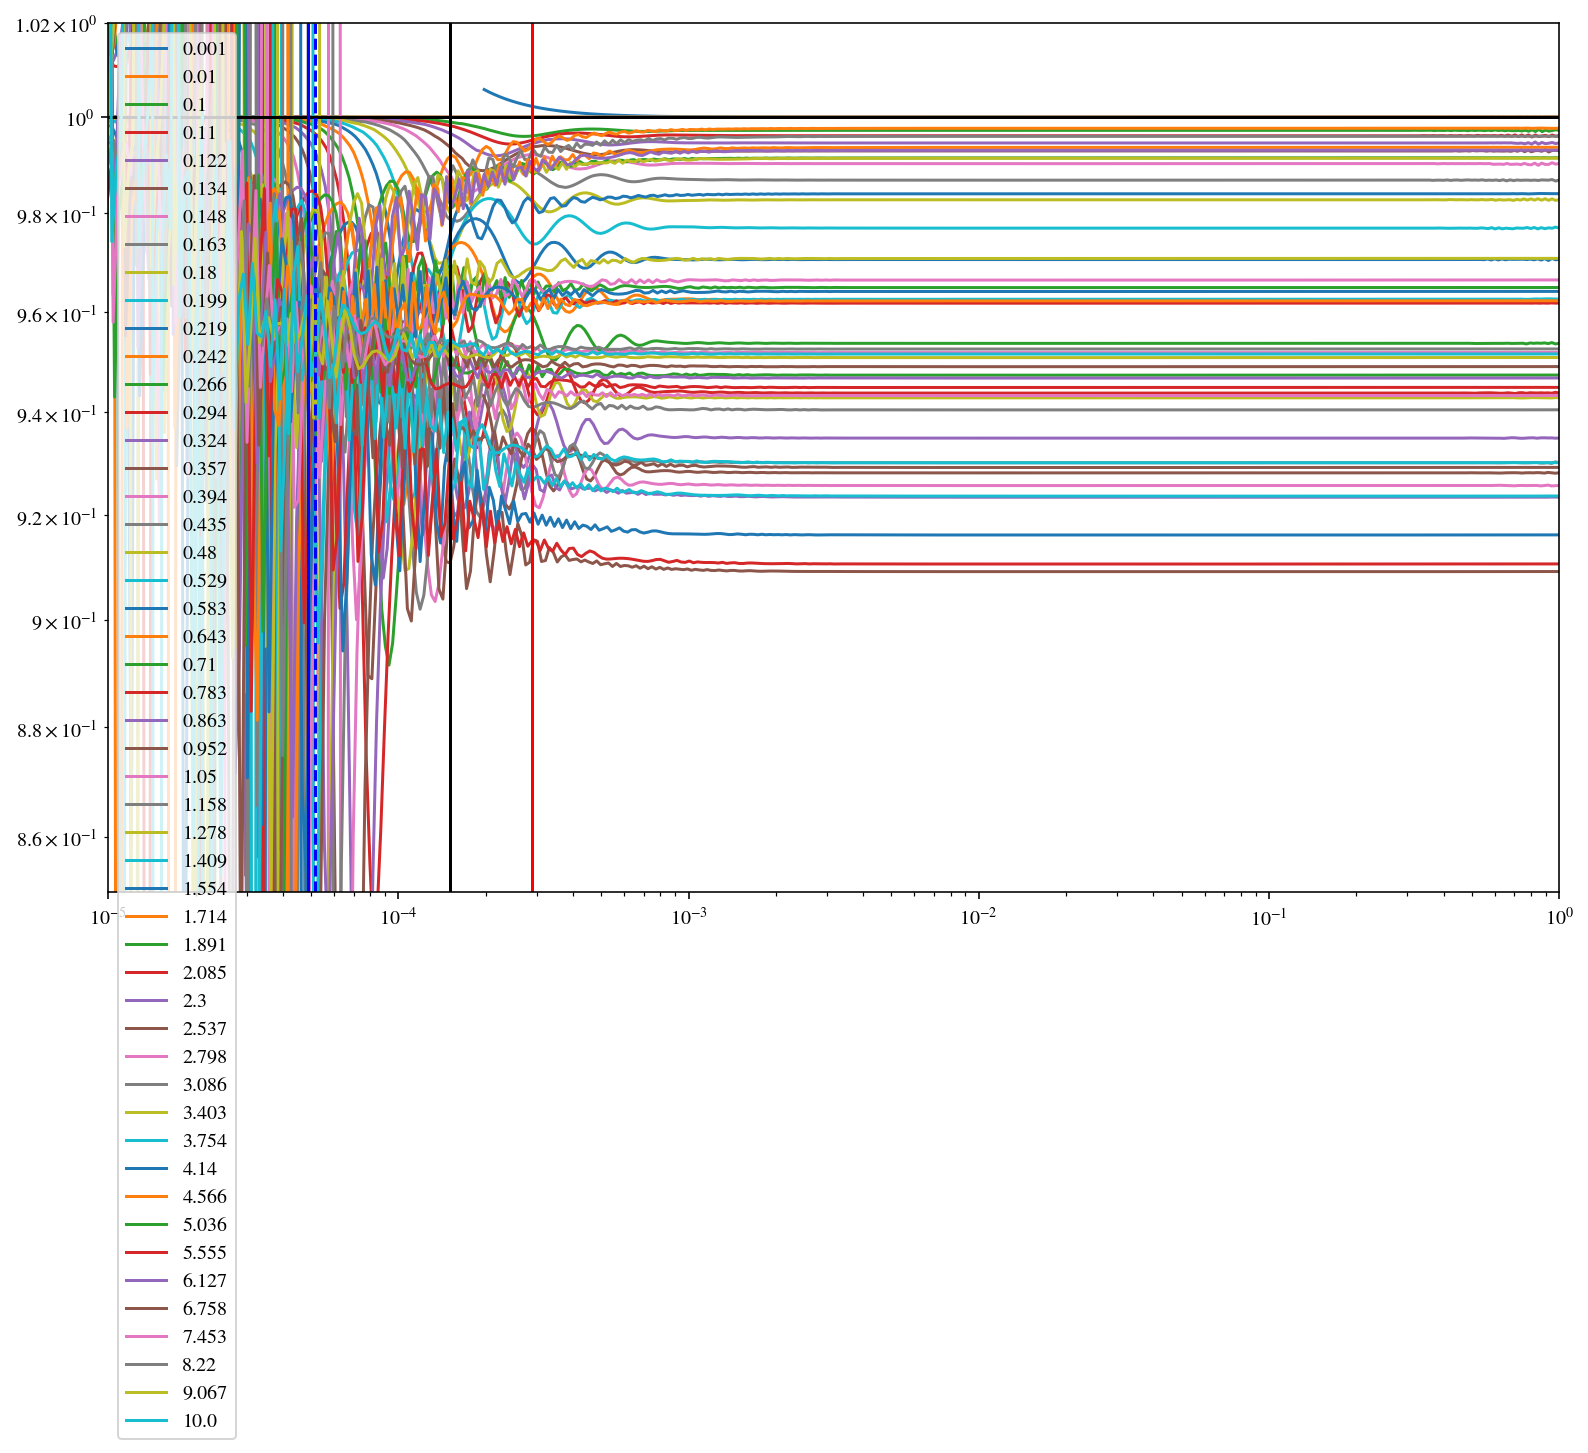

In [15]:
pertu = 'psi'

if pertu == 'delta_idm_dr':
    lpertu = 'delta_cdm'
elif pertu == 'theta_idm_dr':
    lpertu = 'theta_cdm'
elif pertu == 'delta_idr':
    lpertu = 'delta_g'
elif pertu == 'theta_idr':
    lpertu = 'theta_g'
else:
    lpertu = pertu

lcdm_a, lcdm_pert = pert(lcdm, lpertu, 10.)

plt.loglog(lcdm_a, lcdm_pert/lcdm_pert)

for i, k in enumerate(kvals):
    
    lcdm_a, lcdm_pert = pert(lcdm, lpertu, k)
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_pert = pert(nuadam, pertu, k)
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 501)
    
    if i == len(kvals)-1:
        plt.plot(aArr, interp_fn(aArr, Ldcdm)/interp_fn(aArr, Ldcdm), color='k')
    
    plt.plot(aArr, interp_fn(aArr, Ndcdm)/interp_fn(aArr, Ldcdm), label=np.round(k,3), color='C'+str(i), ls='-')
    

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xscale('log')
plt.xlim(1.e-5, 1)
plt.ylim(0.85, 1.02)
plt.legend()
plt.axvline(1./(1.+nuadam.z_eq()), color='r')
plt.axvline(1./(1.+nuadam.z_rec_twin()), color='b')
plt.axvline(a_vel_turn, color='k')
plt.axvline(1./nuadam.z_d_twin(), color='b', ls='--')

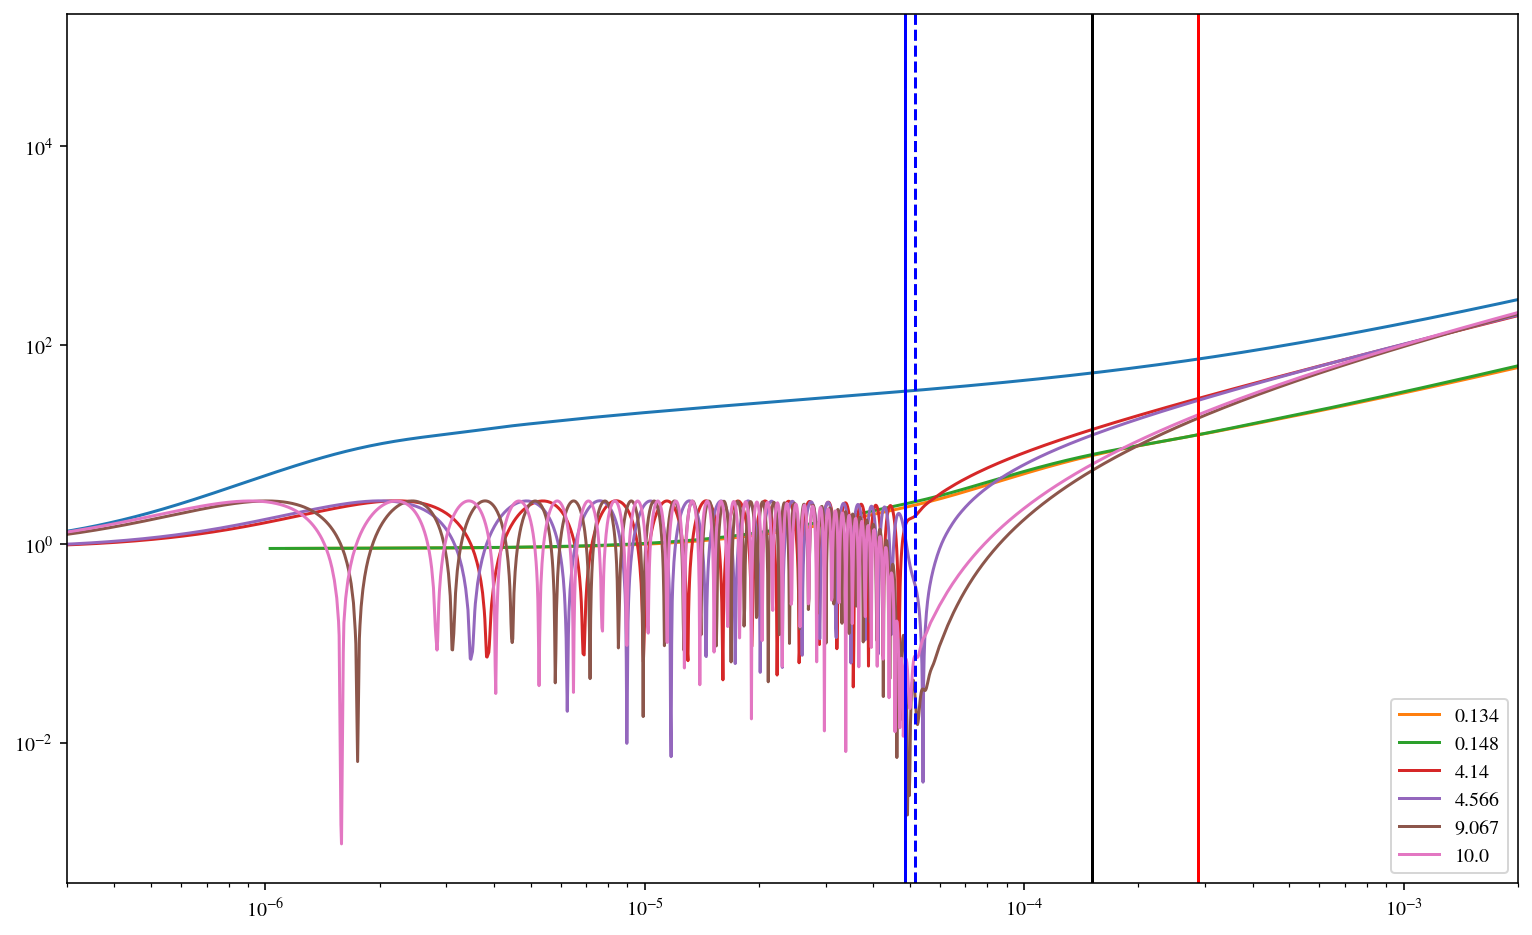

In [64]:
pertu = 'delta_idm_dr'

if pertu == 'delta_idm_dr':
    lpertu = 'delta_cdm'
elif pertu == 'theta_idm_dr':
    lpertu = 'theta_cdm'
elif pertu == 'delta_idr':
    lpertu = 'delta_g'
elif pertu == 'theta_idr':
    lpertu = 'theta_g'
else:
    lpertu = pertu

lcdm_a, lcdm_pert = pert(lcdm, lpertu, 10.)

plt.loglog(lcdm_a, np.abs(lcdm_pert))
for k in (kvals[5:7]+(kvals[-10:-8])+(kvals[-2:])):
# for k in kvals[-5:]:
# for k in kvals[13:29]:
    
    lcdm_a, lcdm_pert = pert(lcdm, lpertu, k)
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_pert = pert(nuadam, pertu, k)
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 5001)
    
    plt.loglog(aArr, interp_fn(aArr, Ndcdm), label=np.round(k,3))
    

# plt.xlim(3.e-5, 5.e-3)
# plt.xlim(1.e-6, 1)
plt.xlim(3.e-7, 2.e-3)
# plt.xlim(0.1,1)
# plt.xlim(4.e-5, 10.e-5)
# plt.ylim(1.e-2, 1.1)
plt.legend(loc='lower right')
plt.axvline(1./(1.+nuadam.z_eq()), color='r')
plt.axvline(1./(1.+nuadam.z_rec_twin()), color='b')
plt.axvline(a_vel_turn, color='k')
plt.axvline(1./nuadam.z_d_twin(), color='b', ls='--')

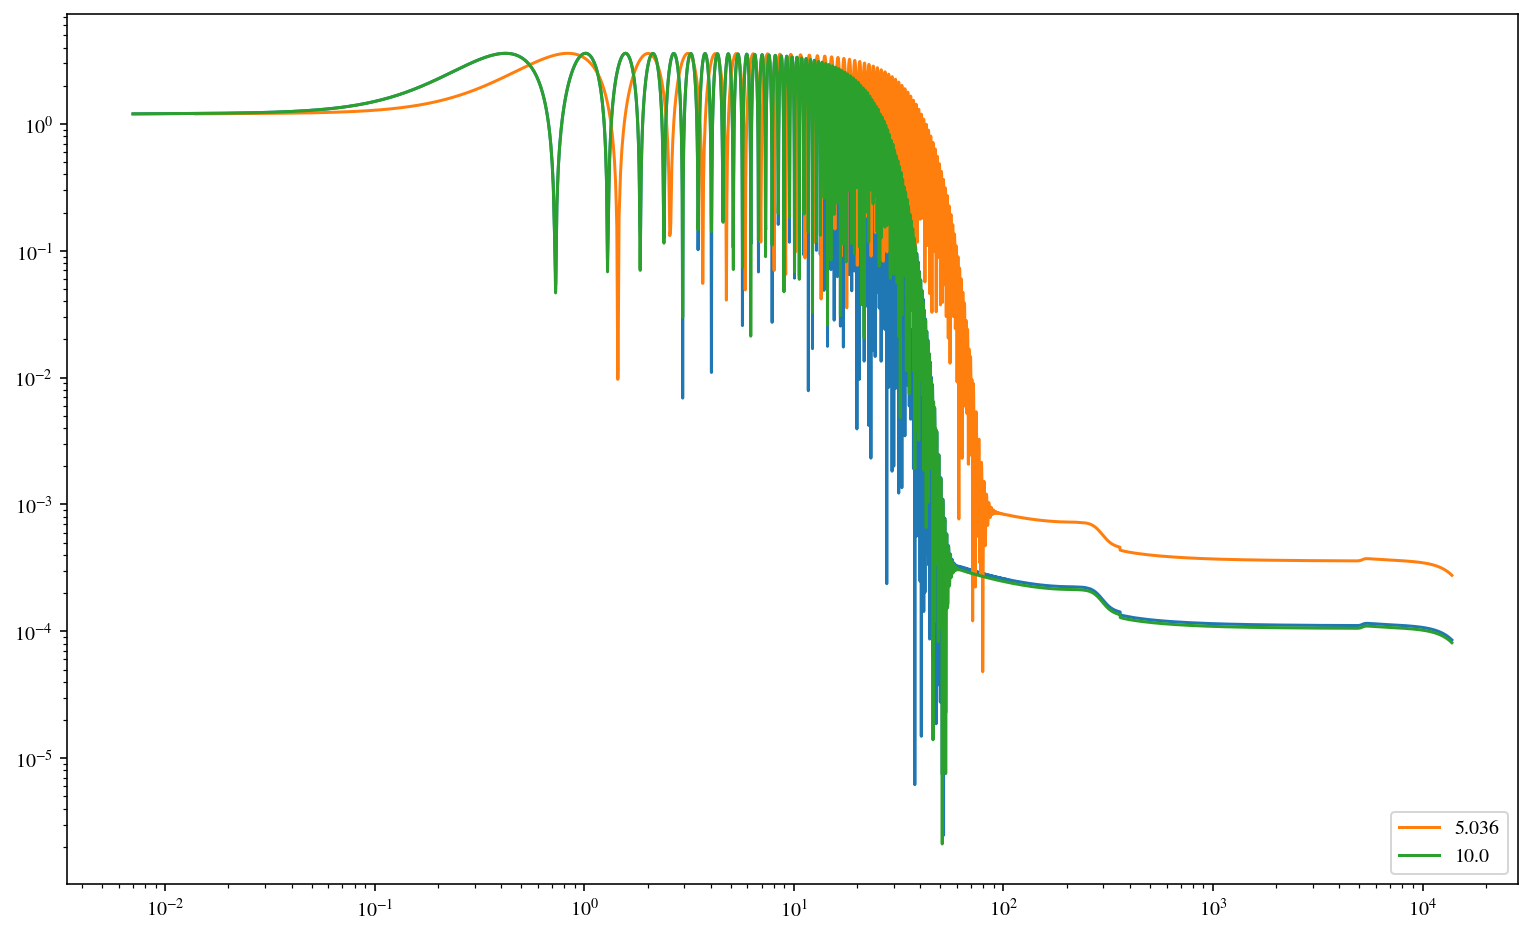

In [91]:
# pertu = 'delta_idm_dr'
pertu = 'delta_g'

if pertu == 'delta_idm_dr':
    lpertu = 'delta_cdm'
elif pertu == 'theta_idm_dr':
    lpertu = 'theta_cdm'
elif pertu == 'delta_idr':
    lpertu = 'delta_g'
elif pertu == 'theta_idr':
    lpertu = 'theta_g'
else:
    lpertu = pertu

lcdm_a, lcdm_pert = pert(lcdm, lpertu, 10., x='tau')

plt.loglog(lcdm_a, np.abs(lcdm_pert))
# for k in (kvals[5:7]+(kvals[-10:-8])+(kvals[-2:])):
for k in ((kvals[-8:-7])+kvals[-1:]):
# for k in kvals[-5:]:
# for k in kvals[13:29]:
    
    lcdm_a, lcdm_pert = pert(lcdm, lpertu, k, x='tau')
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_pert = pert(nuadam, pertu, k, x='tau')
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), np.log10(lcdm_a[-1]), 5001)
    
    plt.loglog(aArr, interp_fn(aArr, Ndcdm), label=np.round(k,3))
    

# plt.xlim(3.e-5, 5.e-3)
# plt.xlim(1.e-6, 1)
# plt.xlim(3.e-7, 2.e-3)
# plt.xlim(0.1,1)
# plt.xlim(4.e-5, 10.e-5)
# plt.ylim(1.e-2, 1.1)
plt.legend(loc='lower right')
# plt.axvline(1./(1.+nuadam.z_eq()), color='r')
# plt.axvline(1./(1.+nuadam.z_rec_twin()), color='b')
# plt.axvline(a_vel_turn, color='k')
# plt.axvline(1./nuadam.z_d_twin(), color='b', ls='--')

In [86]:
nuadam.rs_d_twin()

12.17620403878636

In [85]:
nuadam.rs_drag()

144.78489955578226

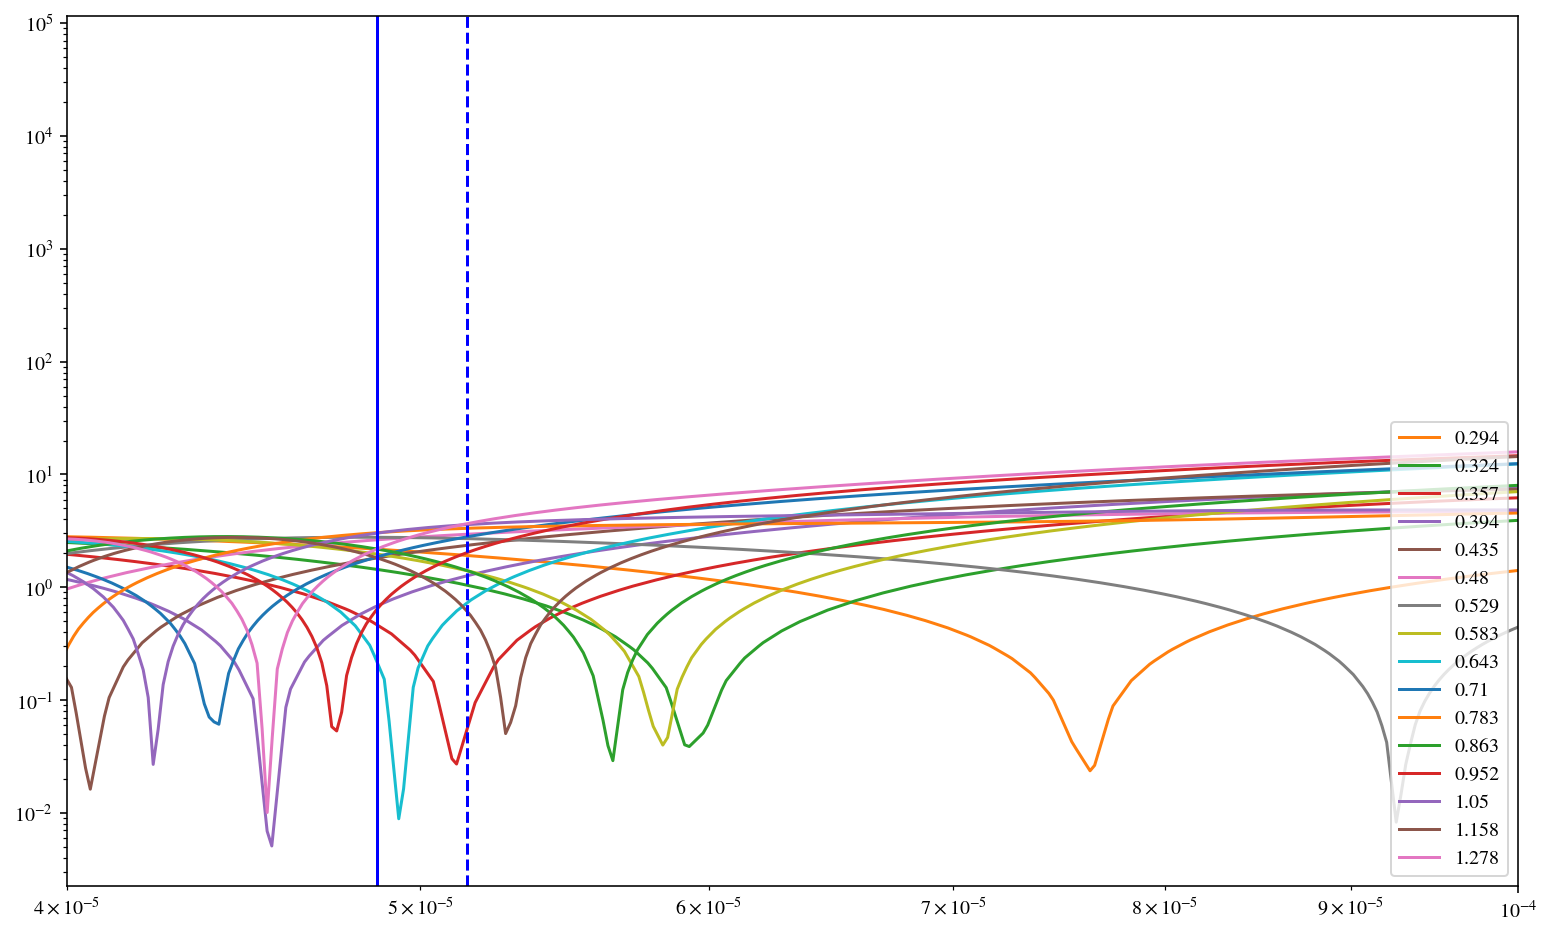

In [28]:
pertu = 'delta_idm_dr'

if pertu == 'delta_idm_dr':
    lpertu = 'delta_cdm'
elif pertu == 'theta_idm_dr':
    lpertu = 'theta_cdm'
elif pertu == 'delta_idr':
    lpertu = 'delta_g'
elif pertu == 'theta_idr':
    lpertu = 'theta_g'
else:
    lpertu = pertu

lcdm_a, lcdm_pert = pert(lcdm, lpertu, 10.)

plt.loglog(lcdm_a, lcdm_pert)

# for k in kvals[-7:]:
for k in kvals[13:29]:
    
    lcdm_a, lcdm_pert = pert(lcdm, lpertu, k)
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_pert = pert(nuadam, pertu, k)
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 5001)
    
    plt.loglog(aArr, interp_fn(aArr, Ndcdm), label=np.round(k,3))
    

# plt.xlim(3.e-5, 5.e-3)
# plt.xlim(1.e-6, 1)
plt.xlim(1.e-5, 5.e-3)
# plt.xlim(0.1,1)
plt.xlim(4.e-5, 10.e-5)
# plt.ylim(1.e-2, 1.1)
plt.legend(loc='lower right')
plt.axvline(1./(1.+nuadam.z_eq()), color='r')
plt.axvline(1./(1.+nuadam.z_rec_twin()), color='b')
plt.axvline(a_vel_turn, color='k')
plt.axvline(1./nuadam.z_d_twin(), color='b', ls='--')

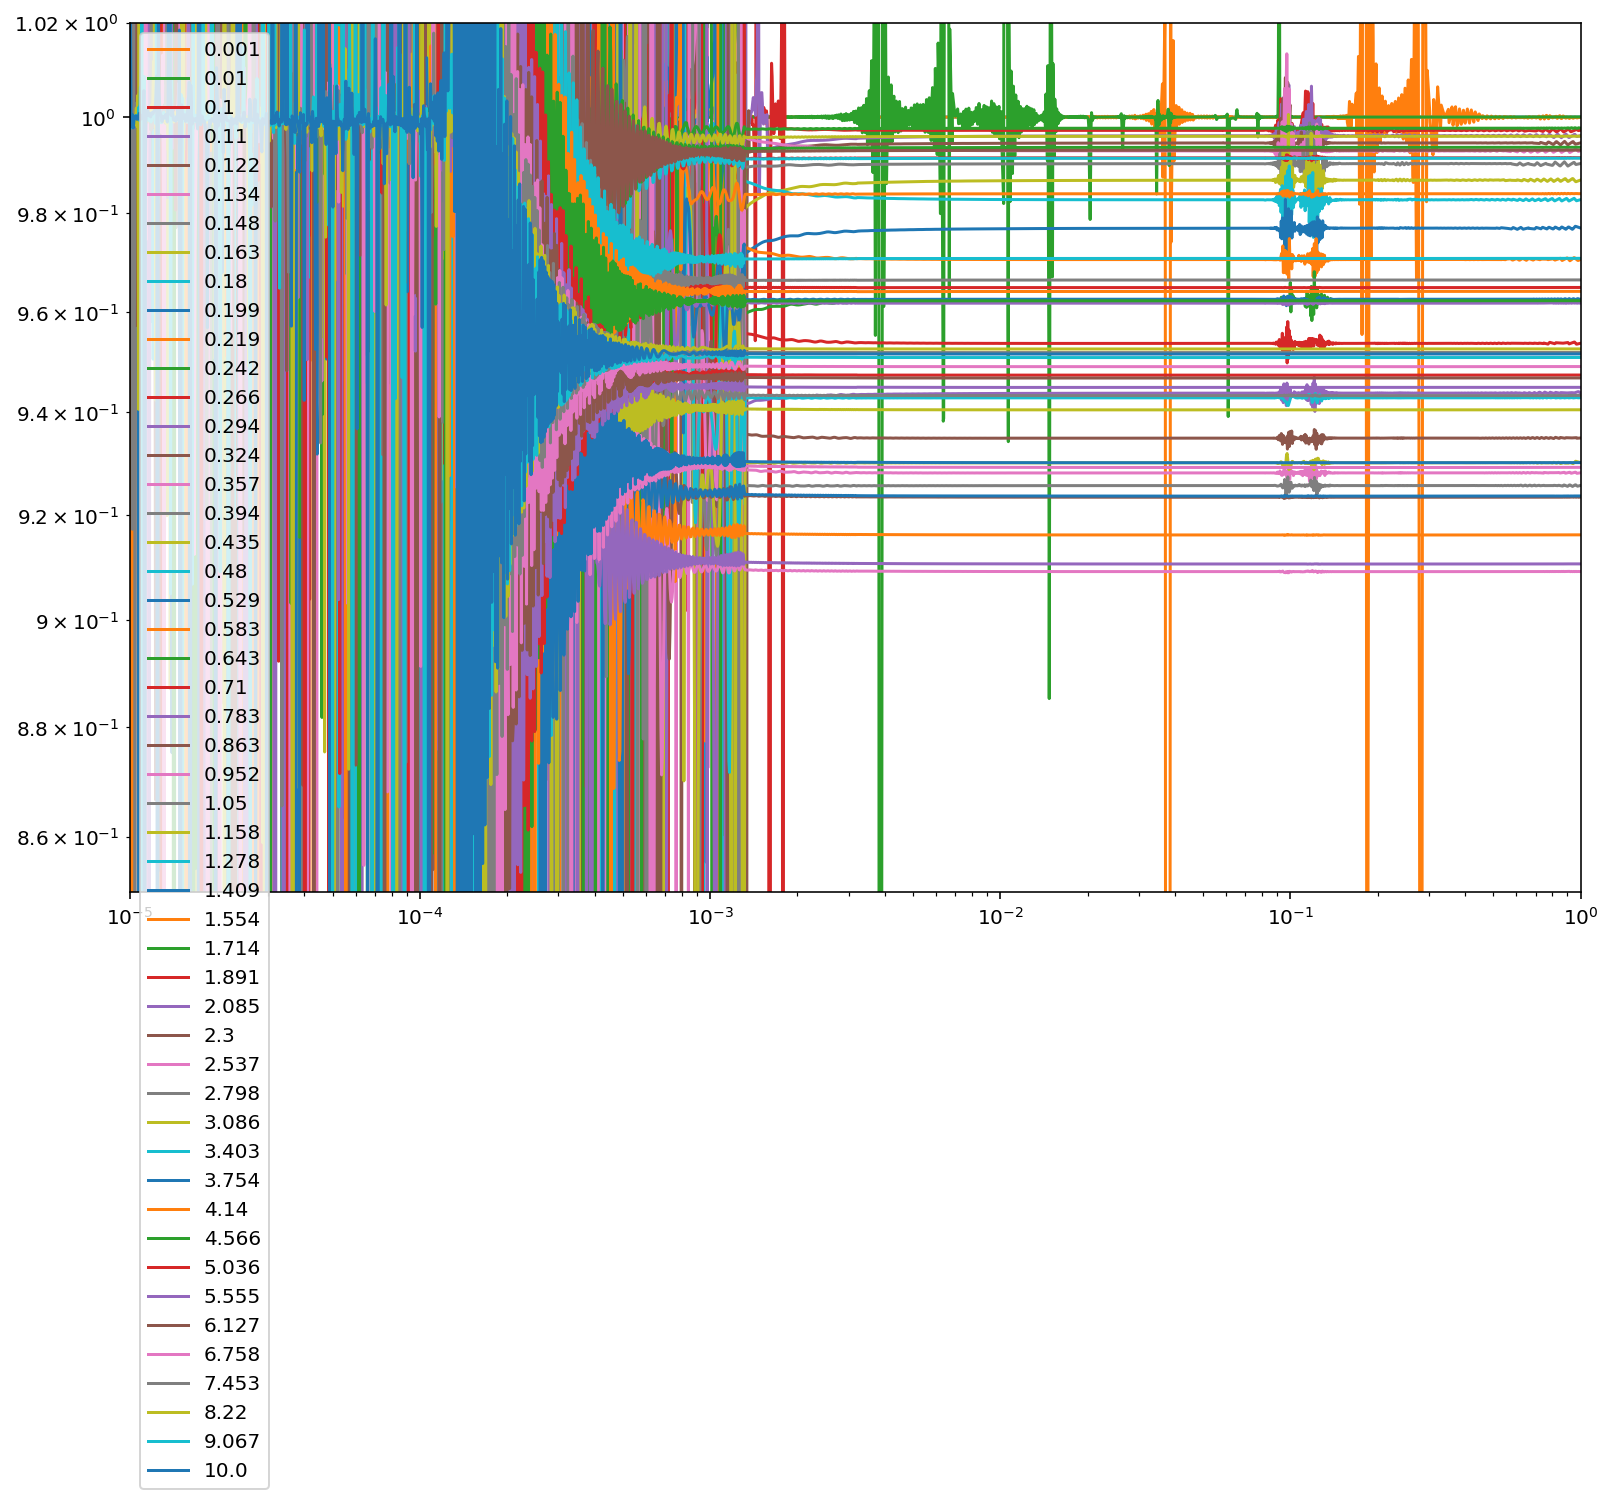

In [22]:
lcdm_a, lcdm_pert = pert(lcdm, 'delta_cdm', 10.)

plt.loglog(lcdm_a, lcdm_pert/lcdm_pert)

for i, k in enumerate(kvals):
    
    lcdm_a, lcdm_psi = pert(lcdm, 'psi', k)
    _, lcdm_dg = pert(lcdm, 'delta_g', k)
    lcdm_pert = 0.25*lcdm_dg + lcdm_psi
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_psi = pert(nuadam, 'psi', k)
    _, nu_dg = pert(nuadam, 'delta_g', k)
    nu_pert = 0.25*nu_dg + nu_psi
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 3001)
    
    plt.plot(aArr, interp_fn(aArr, Ndcdm)/interp_fn(aArr, Ldcdm), label=np.round(k,3))
    

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xscale('log')
plt.xlim(1.e-5, 1)
plt.ylim(0.85, 1.02)
plt.legend()
plt.axvline(1./(1.+nuadam.z_rec_twin()))
plt.axvline(a_vel_turn)
# plt.axvline(1./nuadam.z_d_twin())

## CMB

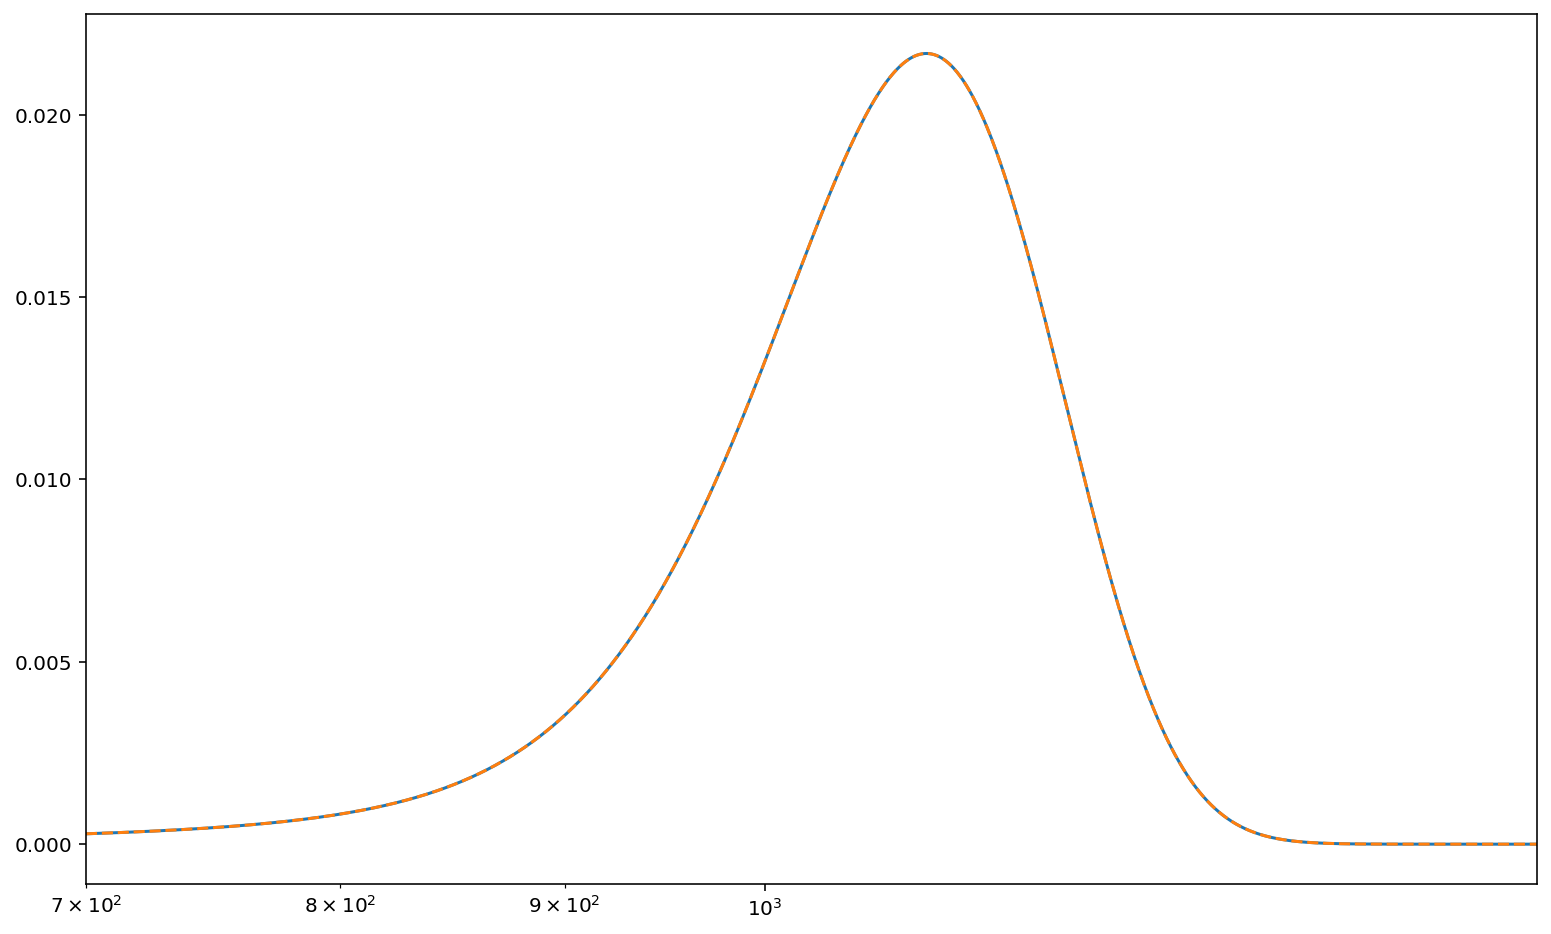

In [23]:
zs0 = lcdm.get_thermodynamics()['z']
gs0 = lcdm.get_thermodynamics()['g [Mpc^-1]']

zs = nuadam.get_thermodynamics()['z']
gs = nuadam.get_thermodynamics()['g [Mpc^-1]']

plt.plot(zs0, gs0)
plt.plot(zs, gs, ls='--')
plt.xscale('log')
plt.xlim(700, 1.5e3);

In [38]:
1/(zs[np.argmax(gs)]+1)

0.0009179516459790964

In [39]:
max(gs)/max(gs0)

0.9999693316715783

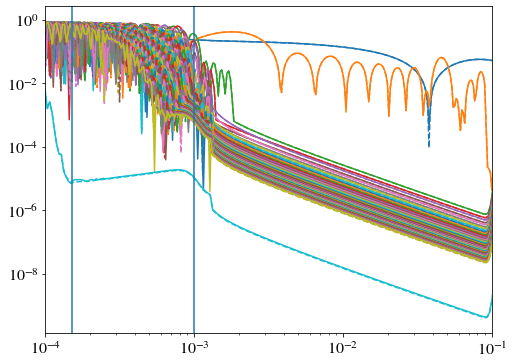

In [40]:
for i, k in enumerate(kvals):
    
    lcdm_a, lcdm_psi = pert(lcdm, 'psi', k)
    _, lcdm_dg = pert(lcdm, 'delta_g', k)
    lcdm_pert = 0.25*lcdm_dg + lcdm_psi
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_psi = pert(nuadam, 'psi', k)
    _, nu_dg = pert(nuadam, 'delta_g', k)
    nu_pert = 0.25*nu_dg + nu_psi
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 501)
    
    plt.loglog(aArr, interp_fn(aArr, Ldcdm), label=np.round(k,3), color='C'+str(i))
    plt.loglog(aArr, interp_fn(aArr, Ndcdm), color='C'+str(i), ls='--')
    

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xlim(1.e-4, 0.1)
# plt.legend(loc='right')
plt.axvline(1./(1.+nuadam.z_rec_twin()))
plt.axvline(1.e-3)
plt.axvline(a_vel_turn)

No handles with labels found to put in legend.


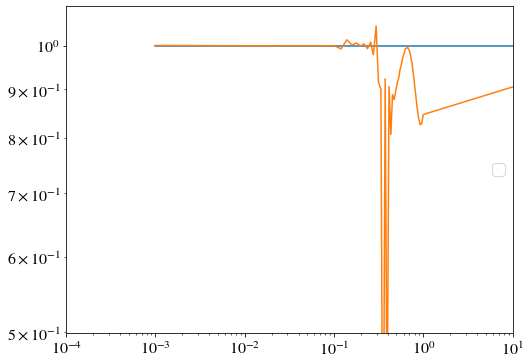

In [41]:
Sk_vals0 = []
Sk_vals = []

for k in kvals:
    
    lcdm_a, lcdm_psi = pert(lcdm, 'psi', k)
    _, lcdm_dg = pert(lcdm, 'delta_g', k)
    _, lcdm_tb = pert(lcdm, 'theta_b', k)
    lcdm_pert = 0.25*lcdm_dg + lcdm_psi# + lcdm_tb/k
    Lpert = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_psi = pert(nuadam, 'psi', k)
    _, nu_dg = pert(nuadam, 'delta_g', k)
    _, nu_tb = pert(nuadam, 'theta_b', k)
    nu_pert = 0.25*nu_dg + nu_psi# + nu_tb/k
    Npert = log_interp_fn(nu_a, np.abs(nu_pert))
    
    a_rec = 1/(zs[np.argmax(gs)]+1)
    
    Sk_vals0.append(interp_fn(a_rec, Lpert)**2.)
    Sk_vals.append(interp_fn(a_rec, Npert)**2.)
    
# plt.loglog(np.array(kvals), Sk_vals0)
# plt.loglog(np.array(kvals), Sk_vals)
plt.loglog(np.array(kvals), np.array(Sk_vals0)/np.array(Sk_vals0))
plt.loglog(np.array(kvals), np.array(Sk_vals)/np.array(Sk_vals0))

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xlim(1.e-4, 10)
plt.ylim(0.5, 1.1)
plt.legend(loc='right')
# plt.axvline(1./(1.+nuadam.z_rec_twin()))
# plt.axvline(1.e-3)
# plt.axvline(a_vel_turn)

In [42]:
lcdm_models = {}
nuadm_models = {}

lcdm_models['all'] = lcdm
nuadm_models['all'] = nuadam

for cont in ['tsw', 'eisw', 'lisw', 'dop', 'pol']:
    
    print(cont)
    
    temp_set = dict(**common_settings)
    temp_set['temperature_contributions'] = cont
    temp_set['k_output_values'] = '1'
    lcdm_models[cont] = Class()
    lcdm_models[cont].set(temp_set)
    lcdm_models[cont].compute()
    
    temp_set = dict(**nuadam_settings)
    temp_set['temperature_contributions'] = cont
    temp_set['k_output_values'] = '1'
    nuadm_models[cont] = Class()
    nuadm_models[cont].set(temp_set)
    nuadm_models[cont].compute()
    
    del temp_set

tsw


KeyboardInterrupt: 

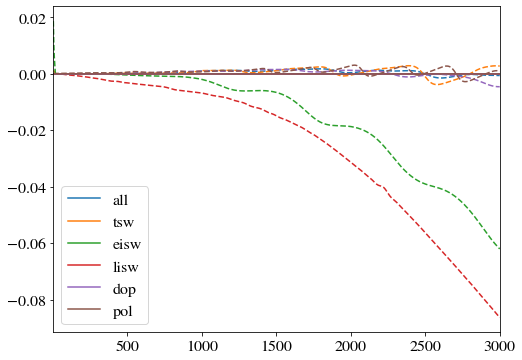

In [26]:
ell = lcdm_models['all'].raw_cl(3000)['ell'][2:]
factor = 1.e10*ell*(ell+1.)/2./pi

# for i, cont in enumerate(['eisw', 'lisw']):
for i, cont in enumerate(['all', 'tsw', 'eisw', 'lisw', 'dop', 'pol']):
# for i, cont in enumerate(['all', 'tsw', 'dop', 'pol']):
    
    ys0 = (lcdm_models[cont].raw_cl(3000)['tt'][2:] / lcdm_models[cont].raw_cl(3000)['tt'][2:]) - 1
    ys1 = (nuadm_models[cont].raw_cl(3000)['tt'][2:] / lcdm_models[cont].raw_cl(3000)['tt'][2:]) - 1
    # ys0 = factor*lcdm_models[cont].raw_cl(3000)['tt'][2:]
    # ys1 = factor*nuadm_models[cont].raw_cl(3000)['tt'][2:]
    
    plt.plot(ell, ys0, label=cont, color='C'+str(i))
    plt.plot(ell, ys1, ls='--', color='C'+str(i))
    
plt.xlim(2, 3.e3)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

## MPS

In [91]:
kArr = np.logspace(-4., 1, 1001)

In [92]:
lc_pk = []
nu_pk = []

for k in kArr:
    lc_pk.append(lcdm.pk_lin(k, 0))
    nu_pk.append(nuadam.pk_lin(k, 0))

lc_pk = np.array(lc_pk)
nu_pk = np.array(nu_pk)

lc_pk *= (lcdm.h()**3.)
nu_pk *= (nuadam.h()**3.)

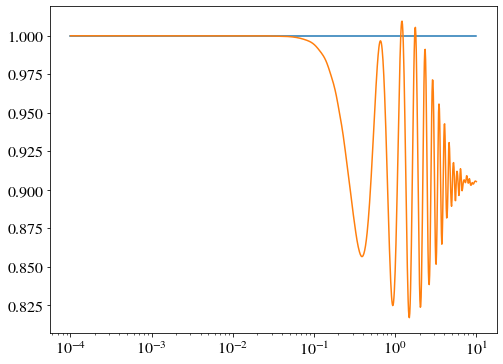

In [93]:
plt.plot(kArr, lc_pk/lc_pk)
plt.plot(kArr, nu_pk/lc_pk)

plt.xscale('log')

# Late Dark Recombination

Small $m_{e'} / m_{p'}$ ratio

## Preamble

In [34]:
# Lambda CDM

bare_settings = {'omega_b':0.02300579,
                 # 'omega_cdm':0.1243789,
                 'omega_dm_tot':0.1243789,
                 # '100*theta_s':1.056498,
                 'h':0.7139304,
                 # 'A_s':2.100549e-09,
                 'ln10^{10}A_s':3.024349,
                 'n_s':0.971559,
                 'tau_reio':0.05018996,
                 'N_ur':2.046,
                 'N_ncdm':1,
                 'm_ncdm':0.06,
                 'T_ncdm':0.7137658555036082,
                 'YHe':'BBN',
                 'output':'tCl,lCl',
                 'lensing':'yes',
                 'YHe_twin':0.0,
                 'm_p_dark':1.,
                 'log10_alphafs_dark':-2.0,
                 'dof_extra_twin':12.5,
                 'log10_me_mp_dark_ratio':0.,
                 'Delta_N_twin':0.1,
                 'r_all_twin':1.e-6}

more_settings = {'P_k_max_1/Mpc':100.0,
                 'z_max_pk':3,
                 'k_output_values':k_str(False),
                 'background_verbose':3,
                 'thermodynamics_verbose':3,
                 'input_verbose':5}

common_settings = dict(bare_settings, **more_settings)
common_settings['output'] = 'tCl,pCl,lCl,mPk'

In [35]:
lcdm = Class()
lcdm.set(common_settings)
%time
lcdm.compute()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [36]:
target_ths = lcdm.theta_s_100()

In [37]:
# lcdm.empty()

In [38]:
# nuADaM

# Fail-point #2
nuadam_settings = {'YHe_twin':0.0,
                   'm_p_dark':1.,
                   'log10_alphafs_dark':-2.0,
                   'dof_extra_twin':12.5,
                   'log10_me_mp_dark_ratio':-5.,
                   'Delta_N_twin':0.1,
                   'r_all_twin':0.04
                  }

nuadam_settings = dict(bare_settings, **nuadam_settings)

# searching for new omega_dm_tot so that z_eq is fixed
nuadam = Class()
nuadam.set(nuadam_settings)
nuadam.compute()

print(lcdm.z_eq(), nuadam.z_eq())

3476.208989622164 3476.2089896221582


In [39]:
# now searching for 'h' such that theta_s is fixed
loop_settings = dict(**nuadam_settings)
loop_settings['h'] = 0.7138951043686523 # found it from previous iteration

h_vals = []
h_vals.append(loop_settings['h'])

hmin = h_vals[-1]*0.9
hmax = h_vals[-1]*1.1

i = 0
while True:
    
    i += 1
    
    if i == 1:
        hpt = h_vals[-1]
    else:
        hpt = (hmax + hmin) / 2.
    
    loop_settings['h'] = hpt
    
    nuadam = Class()
    nuadam.set(loop_settings)
    nuadam.compute()
    
    th_try = nuadam.theta_s_100()
    
    nuadam.empty()
    
    error = (th_try - target_ths)/target_ths
    
    print('h=', hpt, ', theta_s=', th_try, ', error=', error)
    
    if i >= 100:
        print('i >= 100')
        break
    
    if abs(error) < 1.e-4:
        print('done!')
        break
    elif error < 0:
        hmin = hpt
        h_vals.append(hpt)
    else:
        hmax = hpt
        h_vals.append(hpt)

h= 0.7138951043686523 , theta_s= 1.053020522941706 , error= 1.1719669007449894e-05
done!


In [40]:
# now we add the other settings

nuadam_settings['h'] = h_vals[-1]
nuadam_settings['output'] = 'tCl,pCl,lCl,mPk'

nuadam_settings = dict(more_settings, **nuadam_settings)

nuadam = Class()
nuadam.set(nuadam_settings)
nuadam.compute()

In [41]:
kvals = list(klist(False))

def pert(model, yval, k):
    
    idx = kvals.index(k)
    
    results = model.get_perturbations()['scalar'][idx]
    
    xvals = np.array(results['a'])
    yvals = np.array(results[yval])
    
    return xvals, yvals

## Perturbations

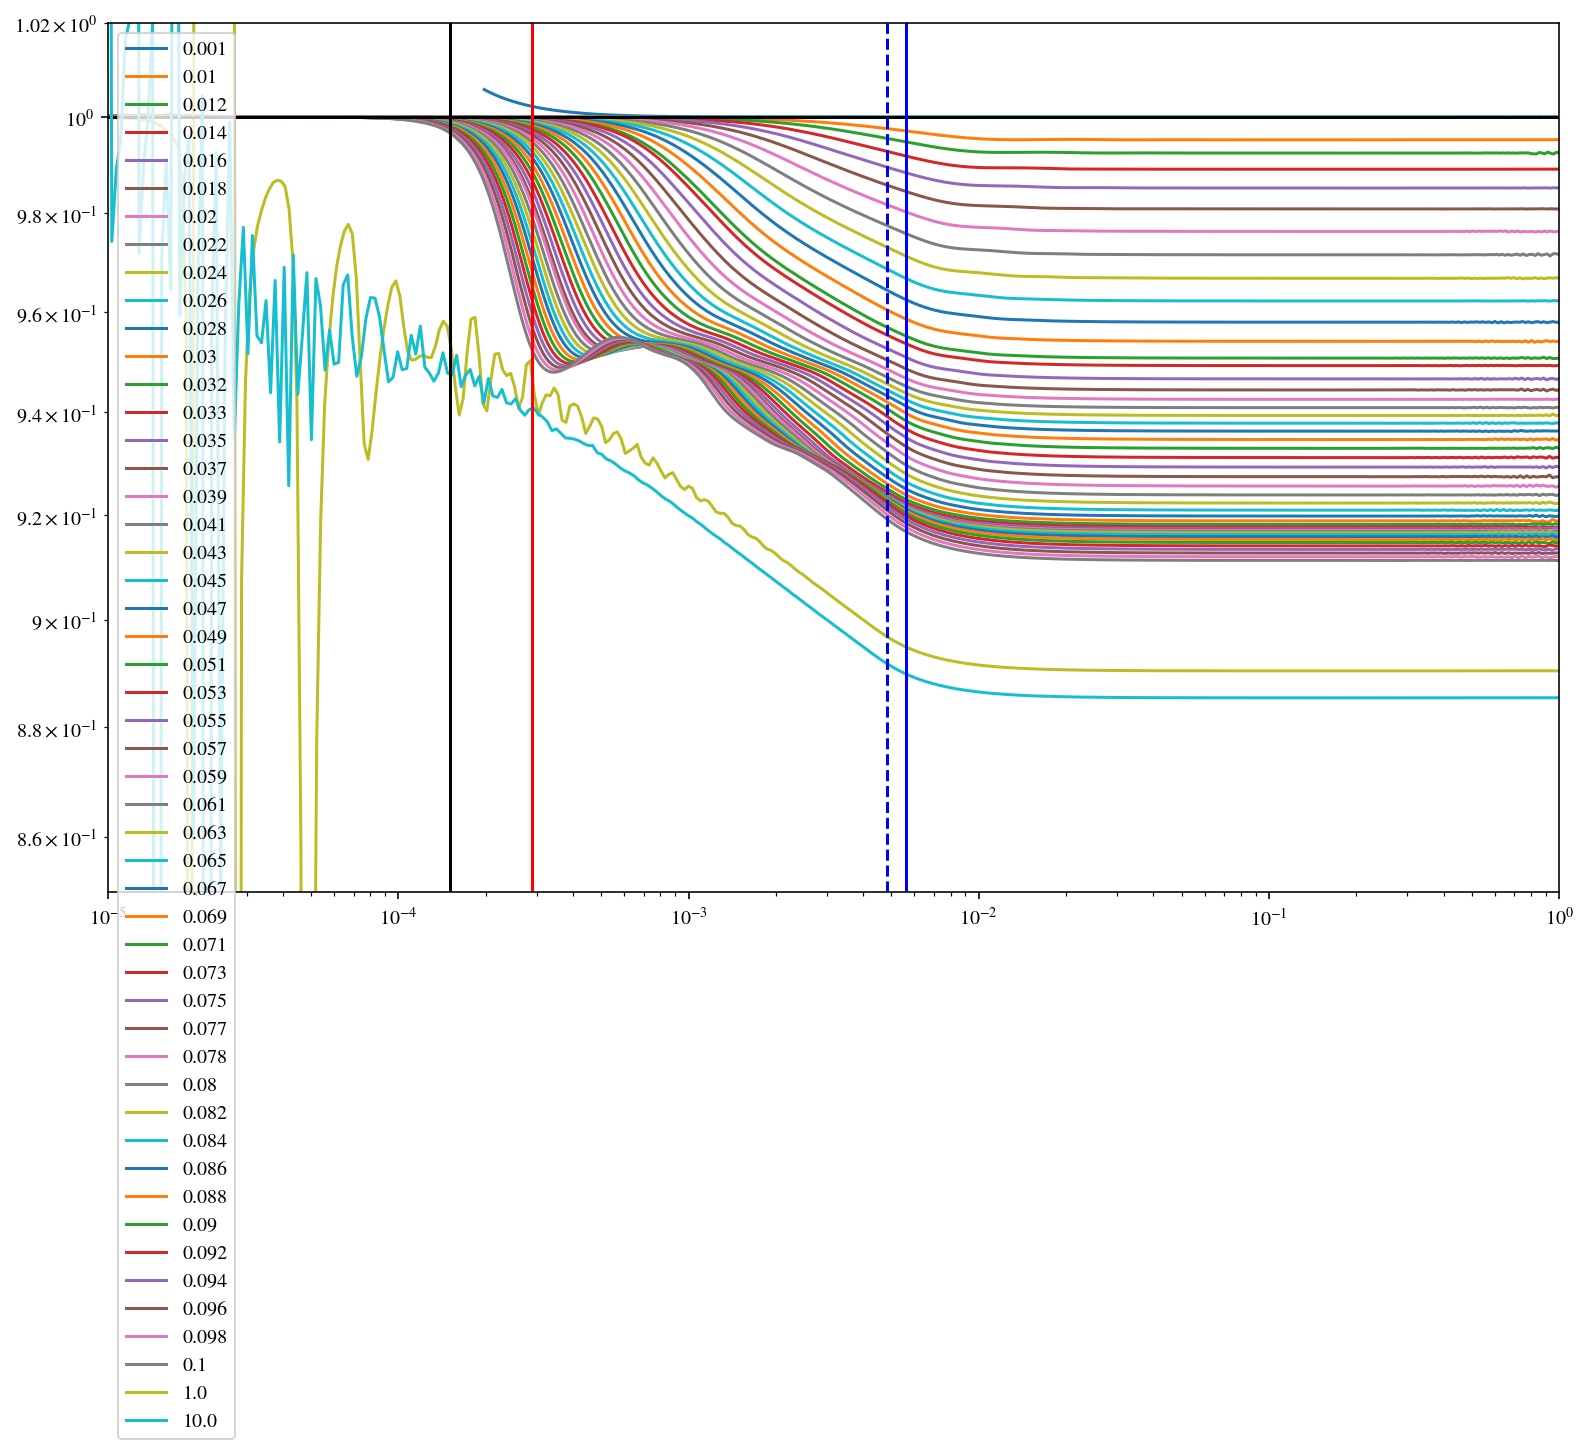

In [62]:
pertu = 'psi'

if pertu == 'delta_idm_dr':
    lpertu = 'delta_cdm'
elif pertu == 'theta_idm_dr':
    lpertu = 'theta_cdm'
elif pertu == 'delta_idr':
    lpertu = 'delta_g'
elif pertu == 'theta_idr':
    lpertu = 'theta_g'
else:
    lpertu = pertu

lcdm_a, lcdm_pert = pert(lcdm, lpertu, 10.)

plt.loglog(lcdm_a, lcdm_pert/lcdm_pert)

for i, k in enumerate(kvals):
    
    lcdm_a, lcdm_pert = pert(lcdm, lpertu, k)
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_pert = pert(nuadam, pertu, k)
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 501)
    
    if i == len(kvals)-1:
        plt.plot(aArr, interp_fn(aArr, Ldcdm)/interp_fn(aArr, Ldcdm), color='k')
    
    plt.plot(aArr, interp_fn(aArr, Ndcdm)/interp_fn(aArr, Ldcdm), label=np.round(k,3), color='C'+str(i), ls='-')
    

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xscale('log')
plt.xlim(1.e-5, 1)
plt.ylim(0.85, 1.02)
plt.legend()
plt.axvline(1./(1.+nuadam.z_eq()), color='r')
plt.axvline(1./(1.+nuadam.z_rec_twin()), color='b')
plt.axvline(a_vel_turn, color='k')
plt.axvline(1./nuadam.z_d_twin(), color='b', ls='--')

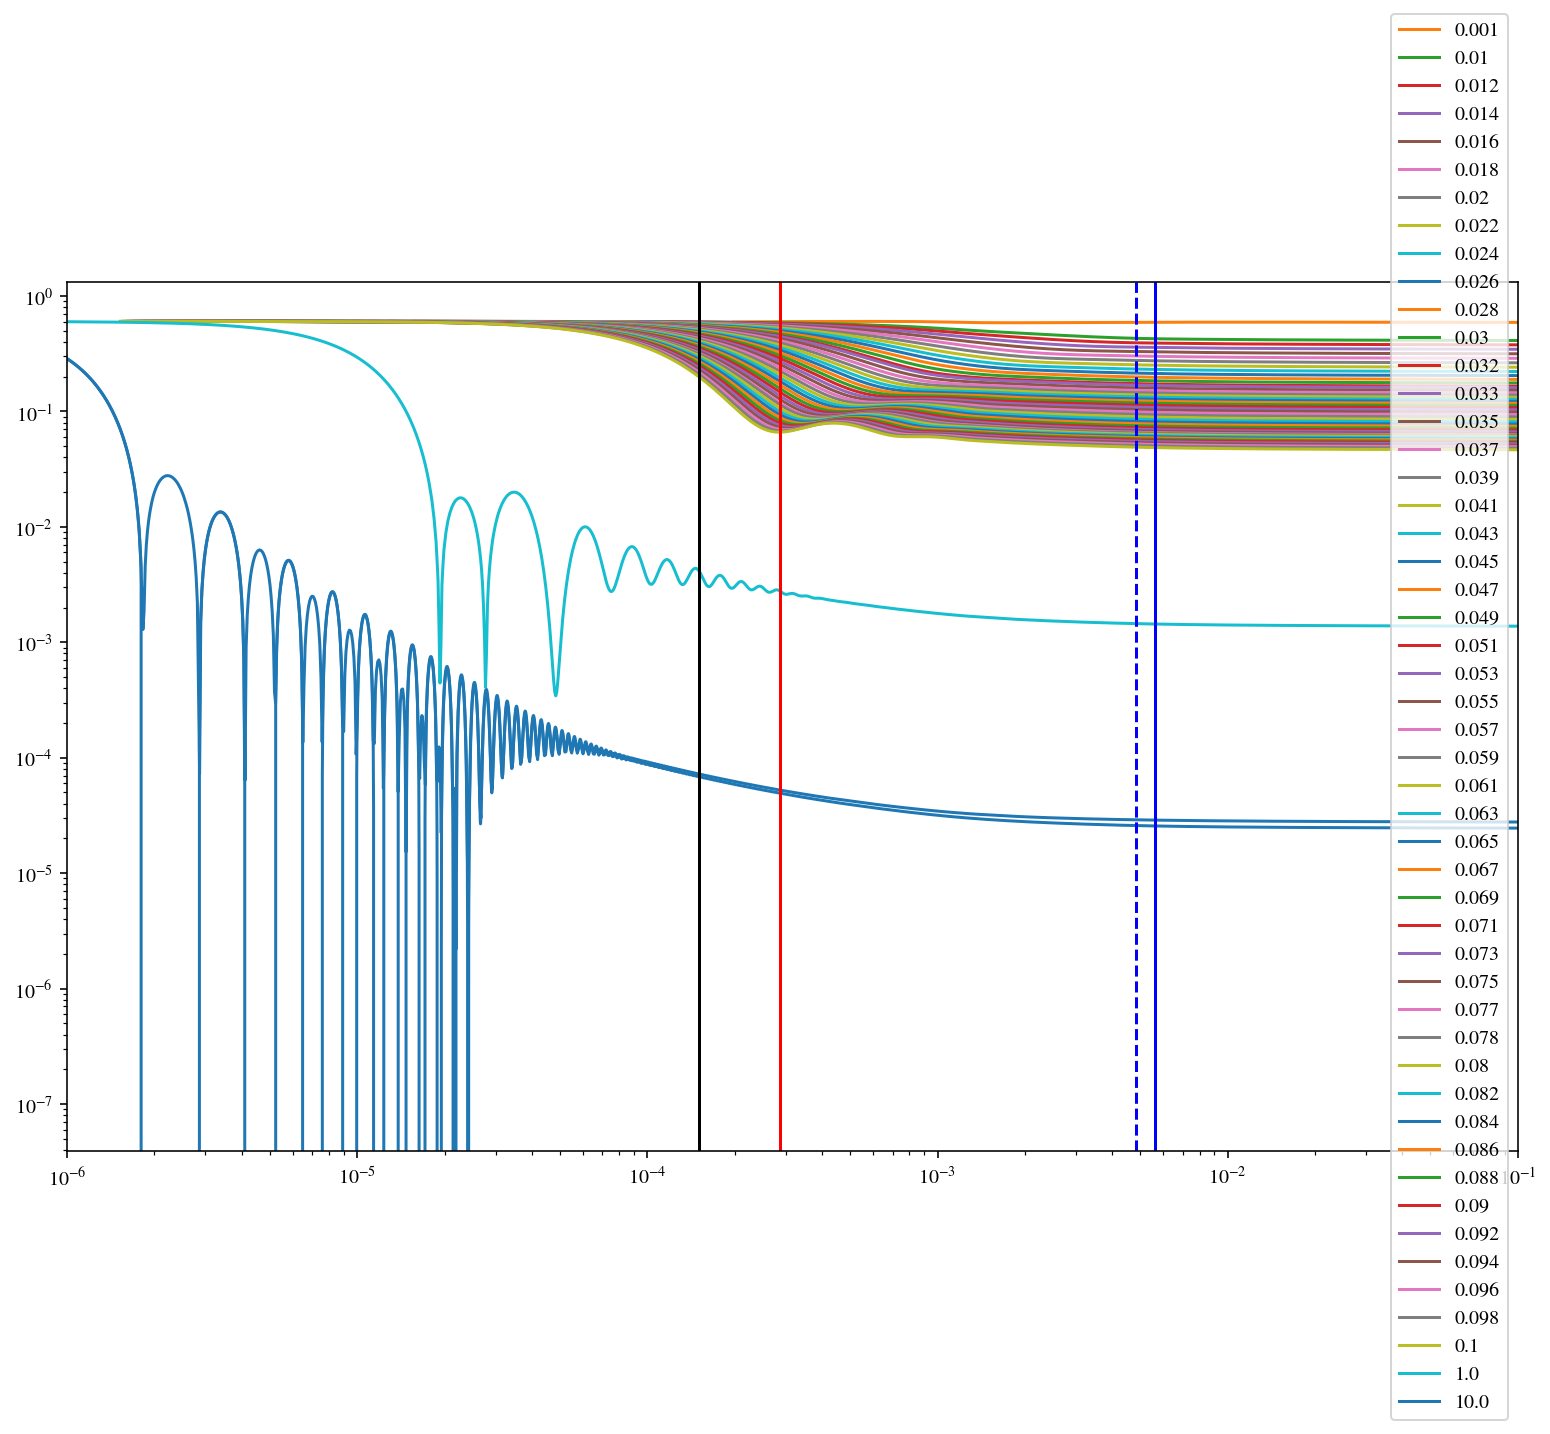

In [60]:
pertu = 'psi'

if pertu == 'delta_idm_dr':
    lpertu = 'delta_cdm'
elif pertu == 'theta_idm_dr':
    lpertu = 'theta_cdm'
elif pertu == 'delta_idr':
    lpertu = 'delta_g'
elif pertu == 'theta_idr':
    lpertu = 'theta_g'
else:
    lpertu = pertu

lcdm_a, lcdm_pert = pert(lcdm, lpertu, 10.)

plt.loglog(lcdm_a, lcdm_pert)

for k in kvals:
    
    lcdm_a, lcdm_pert = pert(lcdm, lpertu, k)
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_pert = pert(nuadam, pertu, k)
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 2001)
    
    plt.loglog(aArr, interp_fn(aArr, Ndcdm), label=np.round(k,3))
    

plt.xlim(1.e-6, 0.1)
# plt.ylim(1.e-5, 1.1)
plt.legend(loc='right')
plt.axvline(1./(1.+nuadam.z_eq()), color='r')
plt.axvline(1./(1.+nuadam.z_rec_twin()), color='b')
plt.axvline(a_vel_turn, color='k')
plt.axvline(1./nuadam.z_d_twin(), color='b', ls='--')

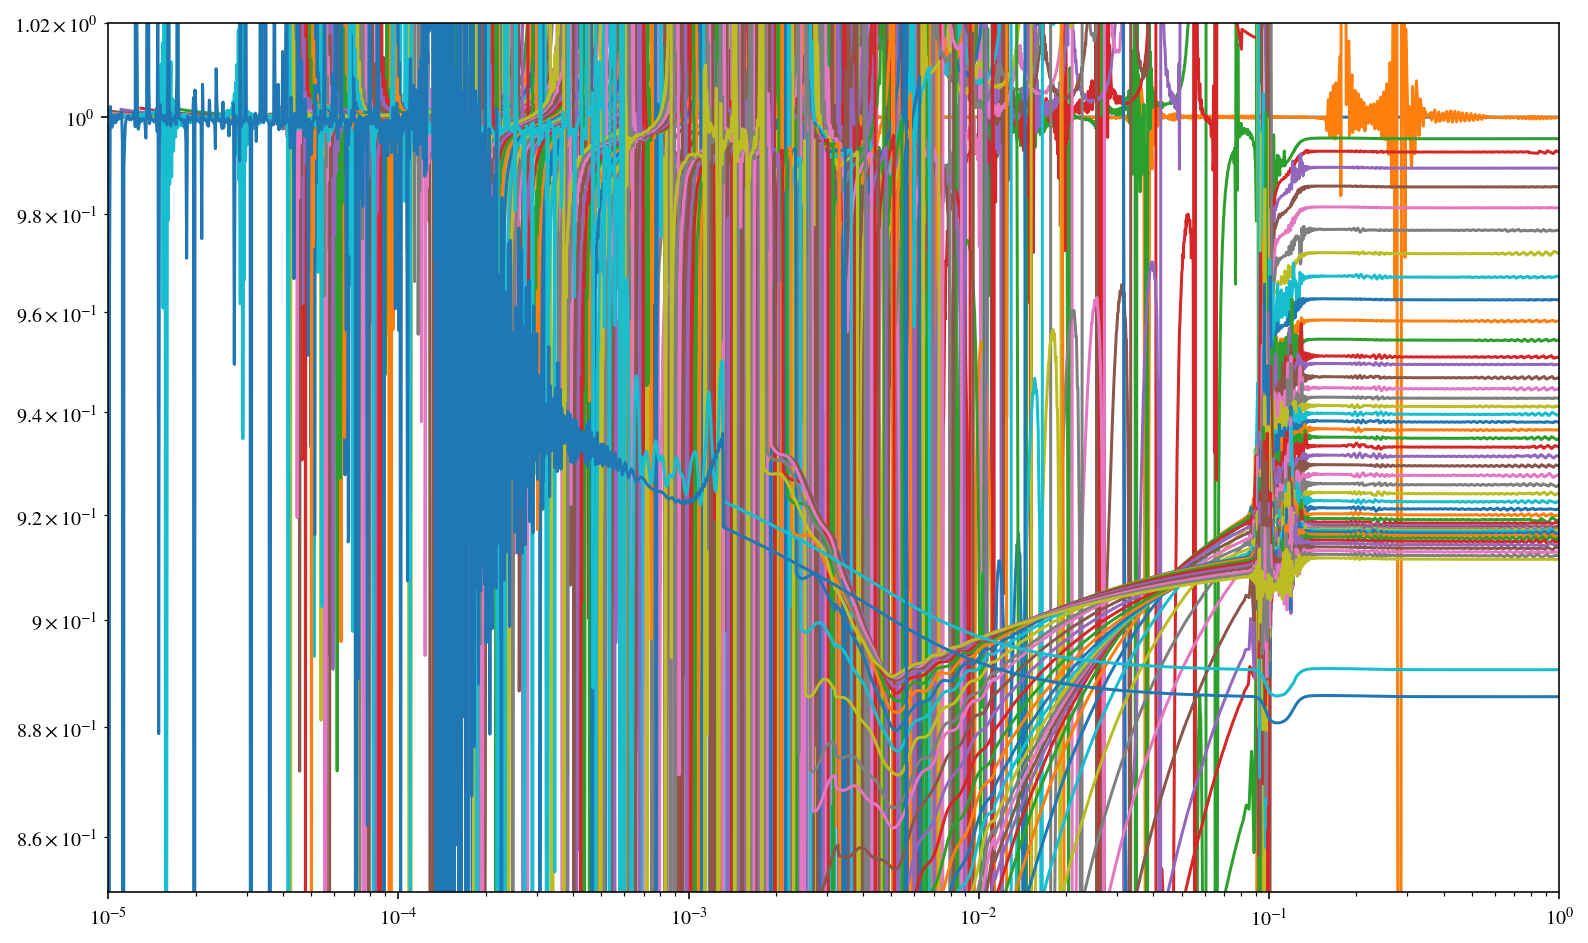

In [44]:
lcdm_a, lcdm_pert = pert(lcdm, 'psi', 10.)

plt.loglog(lcdm_a, lcdm_pert/lcdm_pert)

for i, k in enumerate(kvals):
    
    lcdm_a, lcdm_psi = pert(lcdm, 'psi', k)
    _, lcdm_dg = pert(lcdm, 'delta_g', k)
    lcdm_pert = 0.25*lcdm_dg + lcdm_psi
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_psi = pert(nuadam, 'psi', k)
    _, nu_dg = pert(nuadam, 'delta_g', k)
    nu_pert = 0.25*nu_dg + nu_psi
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 3001)
    
    plt.plot(aArr, interp_fn(aArr, Ndcdm)/interp_fn(aArr, Ldcdm), label=np.round(k,3))
    

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xscale('log')
plt.xlim(1.e-5, 1)
plt.ylim(0.85, 1.02)
# plt.legend()
plt.axvline(1./(1.+nuadam.z_rec_twin()))
plt.axvline(a_vel_turn)
# plt.axvline(1./nuadam.z_d_twin())

## CMB

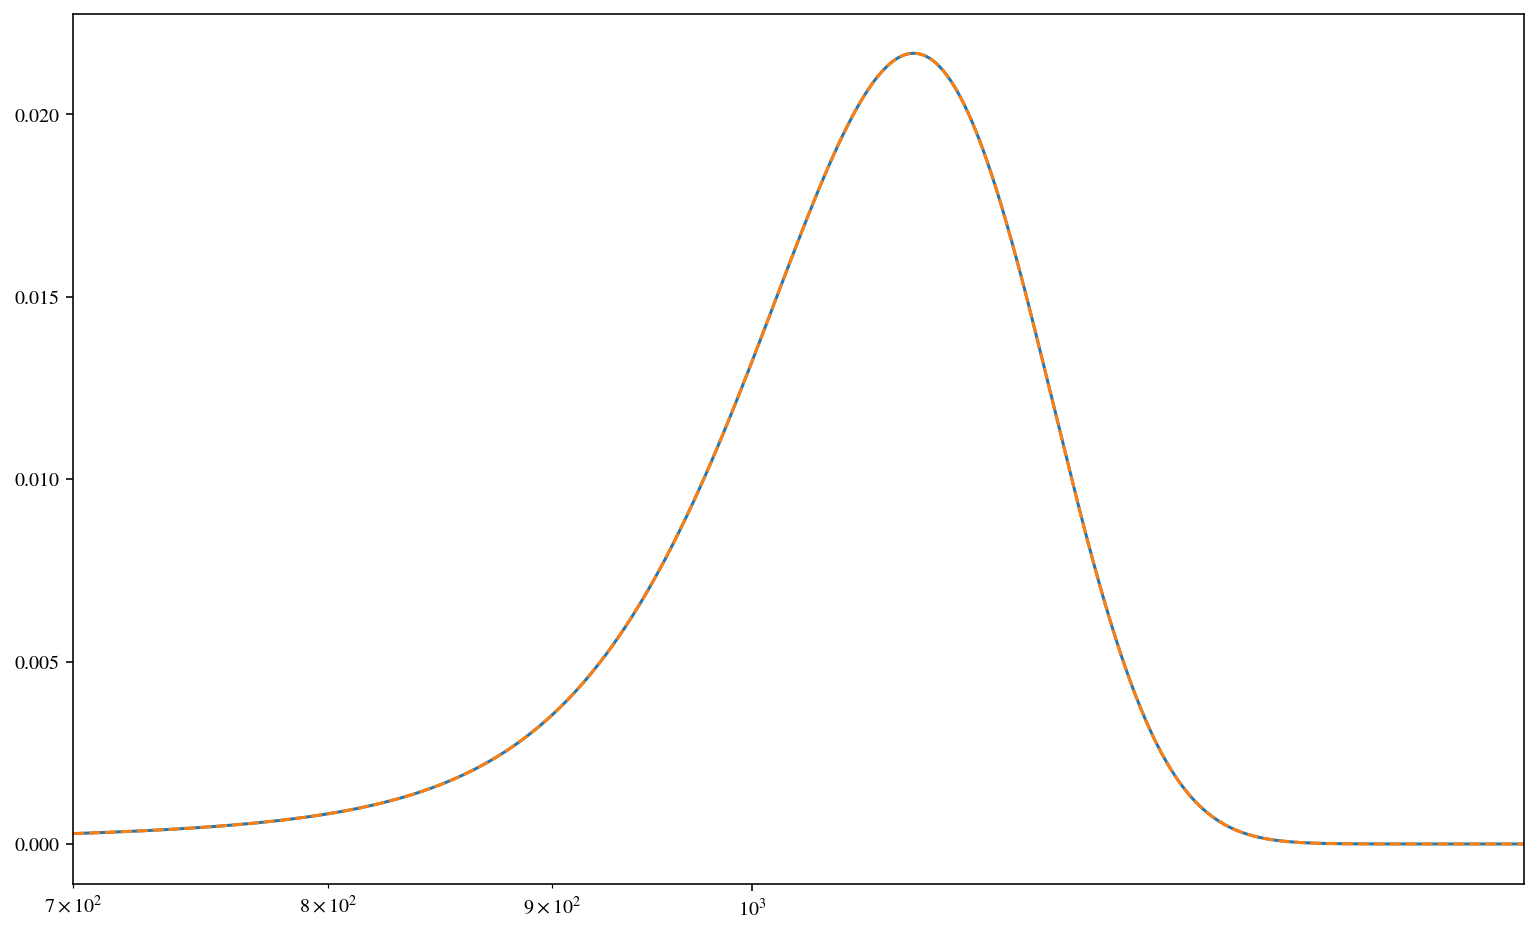

In [45]:
zs0 = lcdm.get_thermodynamics()['z']
gs0 = lcdm.get_thermodynamics()['g [Mpc^-1]']

zs = nuadam.get_thermodynamics()['z']
gs = nuadam.get_thermodynamics()['g [Mpc^-1]']

plt.plot(zs0, gs0)
plt.plot(zs, gs, ls='--')
plt.xscale('log')
plt.xlim(700, 1.5e3);

In [46]:
1/(zs[np.argmax(gs)]+1)

0.0009179516459790964

In [47]:
max(gs)/max(gs0)

1.0000146084976345

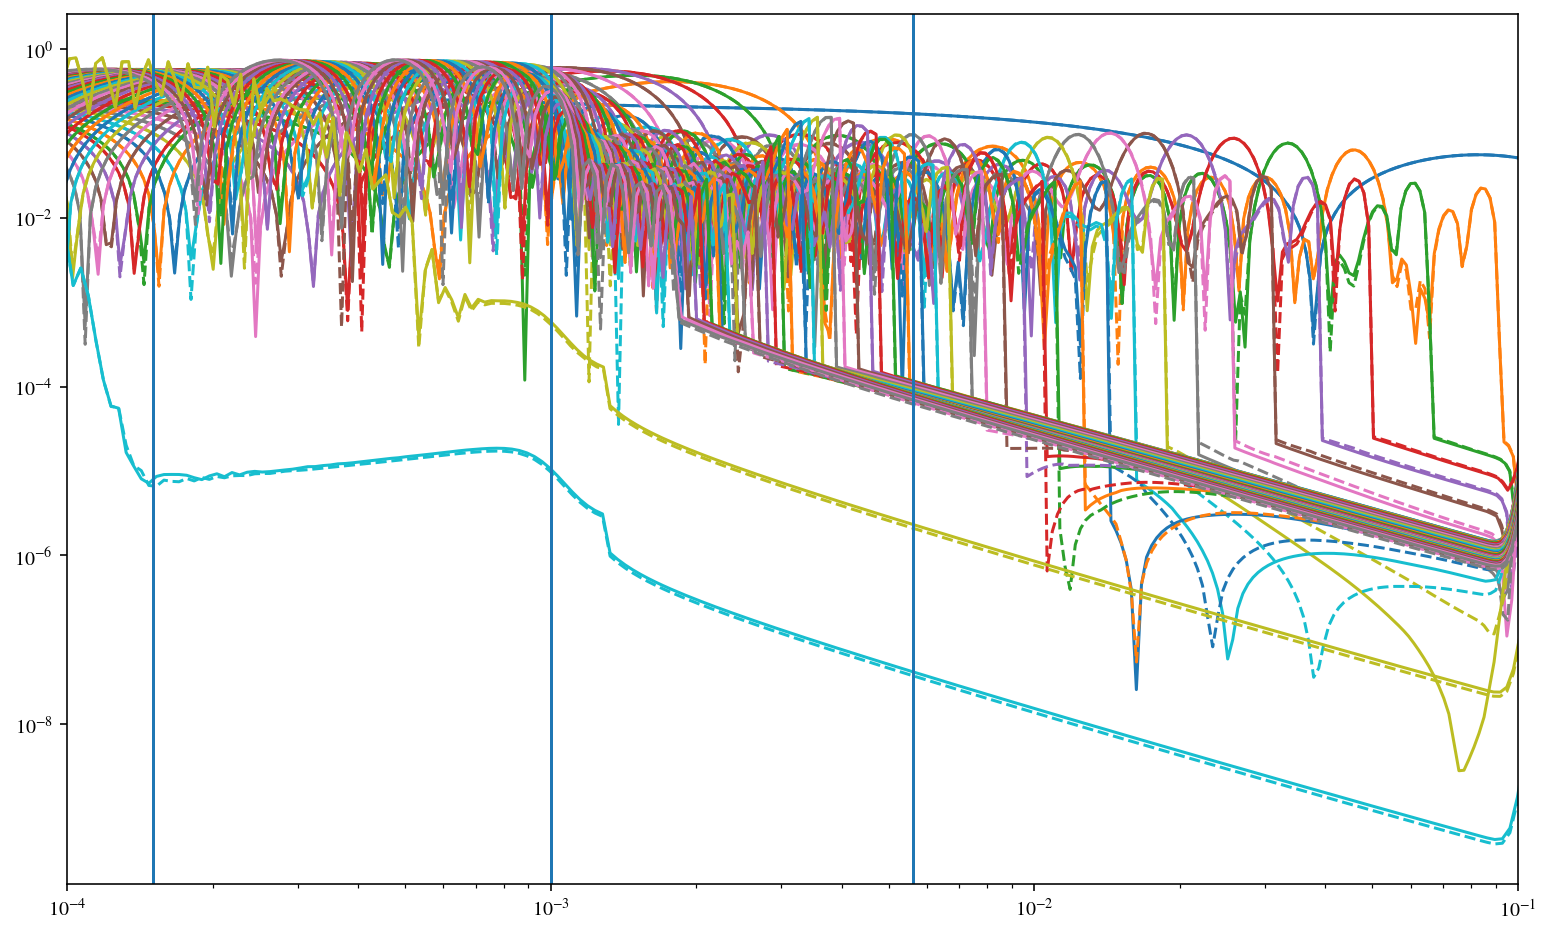

In [48]:
for i, k in enumerate(kvals):
    
    lcdm_a, lcdm_psi = pert(lcdm, 'psi', k)
    _, lcdm_dg = pert(lcdm, 'delta_g', k)
    lcdm_pert = 0.25*lcdm_dg + lcdm_psi
    Ldcdm = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_psi = pert(nuadam, 'psi', k)
    _, nu_dg = pert(nuadam, 'delta_g', k)
    nu_pert = 0.25*nu_dg + nu_psi
    Ndcdm = log_interp_fn(nu_a, np.abs(nu_pert))
    
    aArr = np.logspace(np.log10(max([lcdm_a[0], nu_a[0]])), 0, 501)
    
    plt.loglog(aArr, interp_fn(aArr, Ldcdm), label=np.round(k,3), color='C'+str(i))
    plt.loglog(aArr, interp_fn(aArr, Ndcdm), color='C'+str(i), ls='--')
    

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xlim(1.e-4, 0.1)
# plt.legend(loc='right')
plt.axvline(1./(1.+nuadam.z_rec_twin()))
plt.axvline(1.e-3)
plt.axvline(a_vel_turn)

No handles with labels found to put in legend.


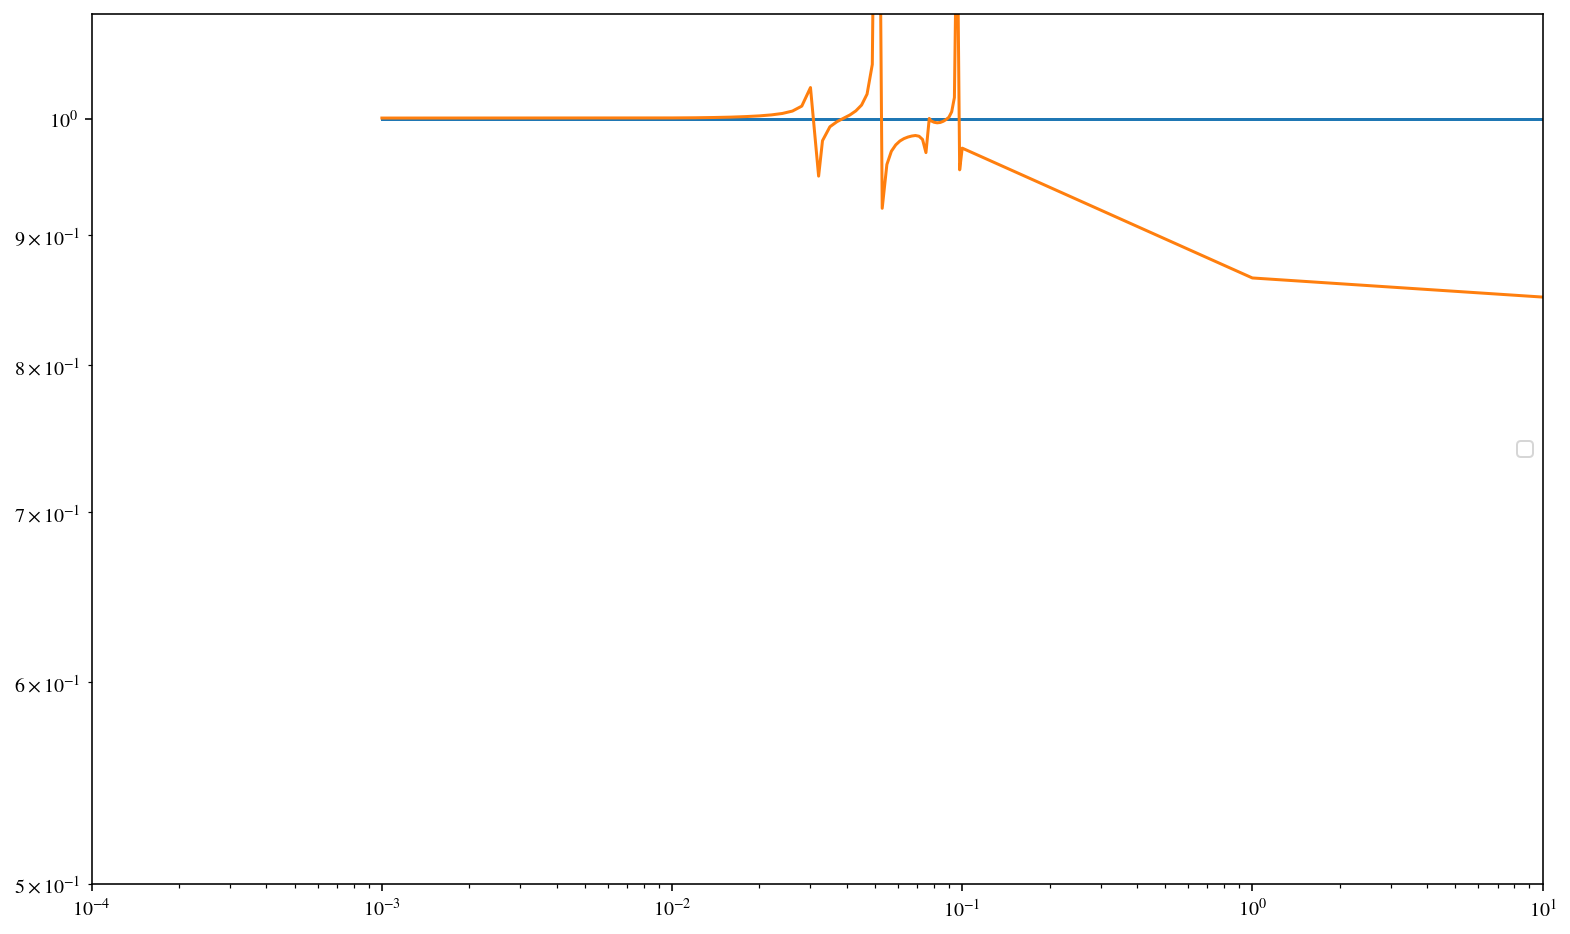

In [49]:
Sk_vals0 = []
Sk_vals = []

for k in kvals:
    
    lcdm_a, lcdm_psi = pert(lcdm, 'psi', k)
    _, lcdm_dg = pert(lcdm, 'delta_g', k)
    _, lcdm_tb = pert(lcdm, 'theta_b', k)
    lcdm_pert = 0.25*lcdm_dg + lcdm_psi# + lcdm_tb/k
    Lpert = log_interp_fn(lcdm_a, np.abs(lcdm_pert))

    nu_a, nu_psi = pert(nuadam, 'psi', k)
    _, nu_dg = pert(nuadam, 'delta_g', k)
    _, nu_tb = pert(nuadam, 'theta_b', k)
    nu_pert = 0.25*nu_dg + nu_psi# + nu_tb/k
    Npert = log_interp_fn(nu_a, np.abs(nu_pert))
    
    a_rec = 1/(zs[np.argmax(gs)]+1)
    
    Sk_vals0.append(interp_fn(a_rec, Lpert)**2.)
    Sk_vals.append(interp_fn(a_rec, Npert)**2.)
    
# plt.loglog(np.array(kvals), Sk_vals0)
# plt.loglog(np.array(kvals), Sk_vals)
plt.loglog(np.array(kvals), np.array(Sk_vals0)/np.array(Sk_vals0))
plt.loglog(np.array(kvals), np.array(Sk_vals)/np.array(Sk_vals0))

a_vel_turn = (4./3)*(nuadam_settings['Delta_N_twin']) * (7./8.*((4./11.)**(4./3.))*nuadam.Omega_g()) / (nuadam_settings['r_all_twin']*nuadam_settings['omega_dm_tot']/(nuadam_settings['h']**2.))

plt.xlim(1.e-4, 10)
plt.ylim(0.5, 1.1)
plt.legend(loc='right')
# plt.axvline(1./(1.+nuadam.z_rec_twin()))
# plt.axvline(1.e-3)
# plt.axvline(a_vel_turn)

In [50]:
lcdm_models = {}
nuadm_models = {}

lcdm_models['all'] = lcdm
nuadm_models['all'] = nuadam

for cont in ['tsw', 'eisw', 'lisw', 'dop', 'pol']:
    
    print(cont)
    
    temp_set = dict(**common_settings)
    temp_set['temperature_contributions'] = cont
    temp_set['k_output_values'] = '1'
    lcdm_models[cont] = Class()
    lcdm_models[cont].set(temp_set)
    lcdm_models[cont].compute()
    
    temp_set = dict(**nuadam_settings)
    temp_set['temperature_contributions'] = cont
    temp_set['k_output_values'] = '1'
    nuadm_models[cont] = Class()
    nuadm_models[cont].set(temp_set)
    nuadm_models[cont].compute()
    
    del temp_set

tsw
eisw
lisw
dop
pol


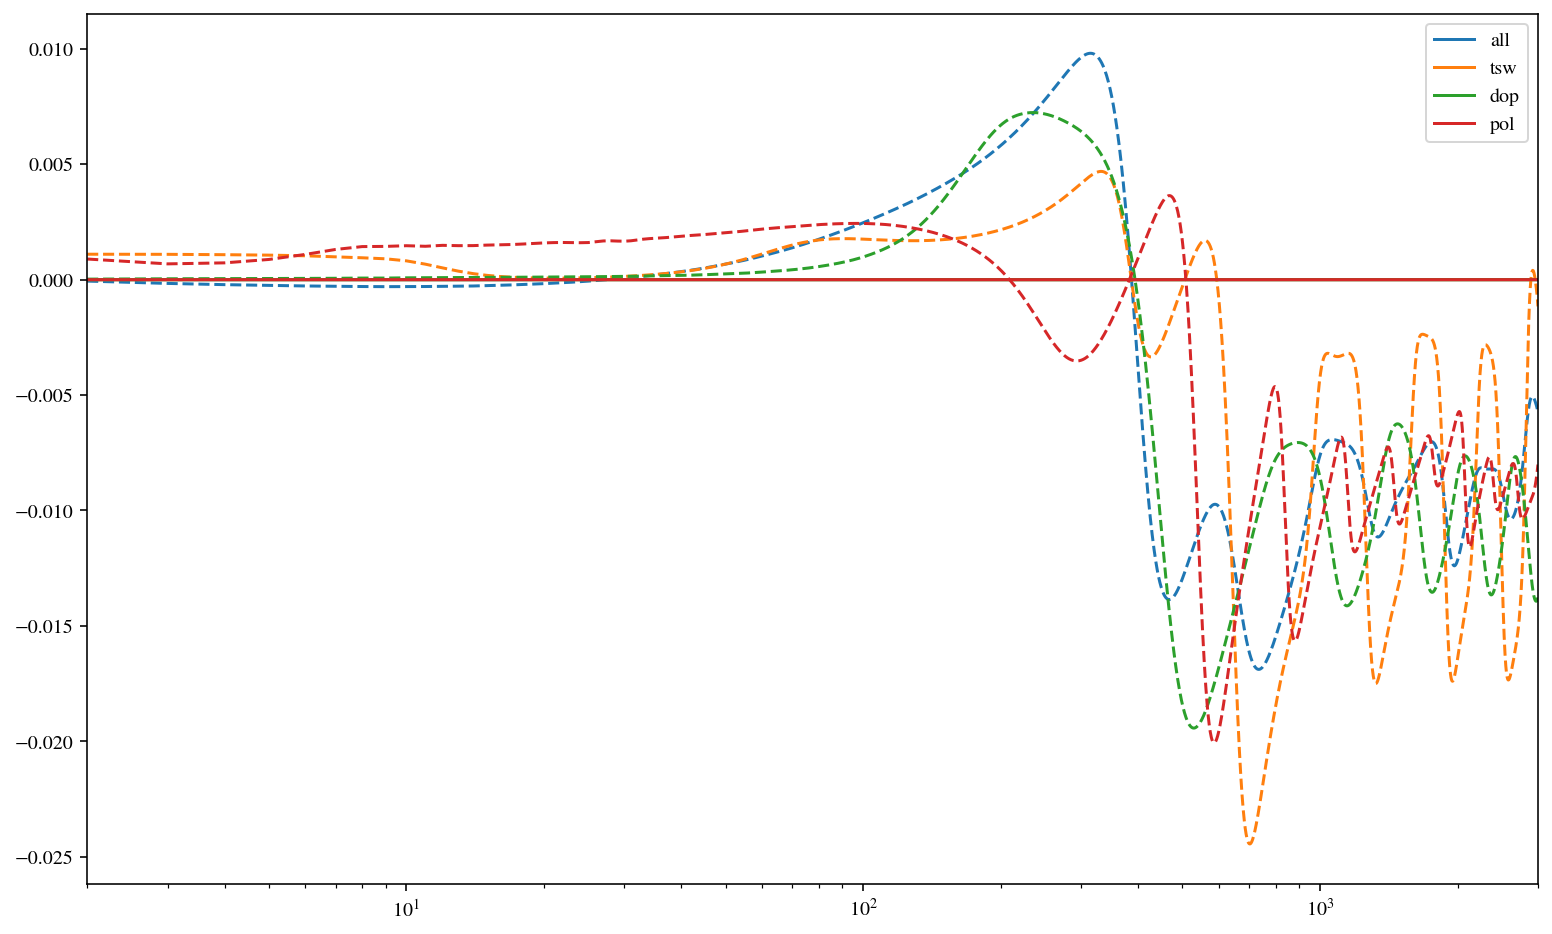

In [65]:
ell = lcdm_models['all'].raw_cl(3000)['ell'][2:]
factor = 1.e10*ell*(ell+1.)/2./pi

# for i, cont in enumerate(['eisw', 'lisw']):
# for i, cont in enumerate(['all', 'tsw', 'eisw', 'lisw', 'dop', 'pol']):
for i, cont in enumerate(['all', 'tsw', 'dop', 'pol']):
    
    ys0 = (lcdm_models[cont].raw_cl(3000)['tt'][2:] / lcdm_models[cont].raw_cl(3000)['tt'][2:]) - 1
    ys1 = (nuadm_models[cont].raw_cl(3000)['tt'][2:] / lcdm_models[cont].raw_cl(3000)['tt'][2:]) - 1
    # ys0 = factor*lcdm_models[cont].raw_cl(3000)['tt'][2:]
    # ys1 = factor*nuadm_models[cont].raw_cl(3000)['tt'][2:]
    
    plt.plot(ell, ys0, label=cont, color='C'+str(i))
    plt.plot(ell, ys1, ls='--', color='C'+str(i))
    
plt.xlim(2, 3.e3)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

## MPS

In [52]:
kArr = np.logspace(-4., 1, 1001)

In [53]:
lc_pk = []
nu_pk = []

for k in kArr:
    lc_pk.append(lcdm.pk_lin(k, 0))
    nu_pk.append(nuadam.pk_lin(k, 0))

lc_pk = np.array(lc_pk)
nu_pk = np.array(nu_pk)

lc_pk *= (lcdm.h()**3.)
nu_pk *= (nuadam.h()**3.)

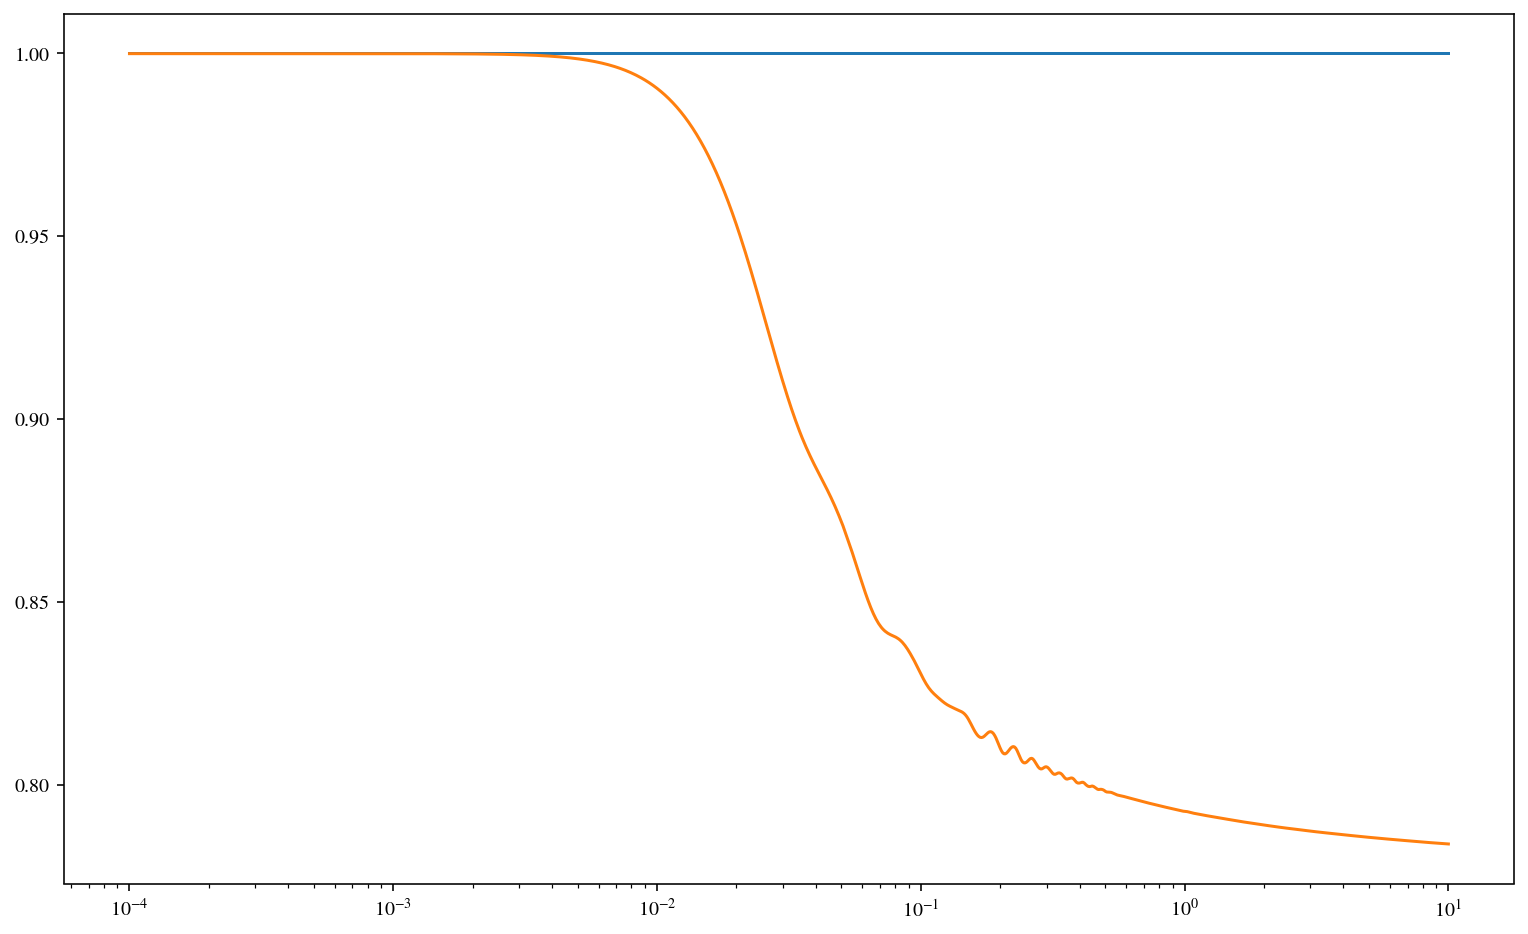

In [54]:
plt.plot(kArr, lc_pk/lc_pk)
plt.plot(kArr, nu_pk/lc_pk)

plt.xscale('log')